
# Introduction

The task is to build the model which approximates and generalizes QW and DP for arbitrary values of s_mt, s_mq, d, h_p within the range of their variation (Table 1).

**Project Overview and Objectives**

This project focuses on developing a machine learning model to approximate and generalize two key parameters: QW (Quality Width) and DP (Depth Penetration) based on four input variables:
- Input features (4):
  - s_mt
  - s_mq
  - d
  - h_p
- Target variables (2):
  - QW
  - DP

Feature naming convention assumptions, read the note below:

- s_mt: Material thickness 
- s_mq: Material quality
- d: Diameter
- h_p: Height parameter

's_mt' interpretation as 'material thickness' is based on:
1. Common engineering notation where:
   - 's' often refers to size/section parameters
   - 'mt' is a widespread abbreviation for 'material thickness' in:
      * Manufacturing documentation
      * CAD/CAM systems
's_mq' interpretation as 'material quality' is based on:
1. Industrial standards where:
   - 's' could refer to specification/standard
   - 'mq' is commonly used for 'material quality' in:
      * Quality control documentation
      * Manufacturing specifications

Note: The following interpretations are assumptions and should be verified:
- s_mt could potentially stand for material thickness (needs verification)
- s_mq could potentially stand for material quality (needs verification)
Actual meanings should be confirmed through documentation or domain experts.

**Objectives:**
1. Build and compare regression models for QW and DP prediction
2. Analyze relationships between features and target variables
3. Evaluate model performance using R² metric
4. Investigate how model performance depends on training data volume

**Methodology:**
1. Data quality assessment
2. Exploratory data analysis
3. Feature analysis and visualization
4. Model selection and training
5. Performance evaluation
6. Data volume impact analysis

Note: Specific feature descriptions should be provided by domain experts or documentation.

**Objectives:**
1. Build a regression model that accurately predicts QW and DP values
2. Analyze the relationship between input parameters and target variables
3. Compare different ML algorithms performance
4. Determine optimal data volume requirements

**Dataset Description:**
- Input features: 4 (s_mt, s_mq, d, h_p)
- Target variables: 2 (QW, DP)
- Data format: CSV file
- Expected value ranges are defined in Table 1 of specifications

**Success Metrics:**
- Primary metric: R² score (coefficient of determination)
- Model evaluation on both training and test sets
- Analysis of model performance with varying data volumes

**Methodology:**
1. Data quality assessment and preprocessing
2. Feature analysis and visualization
3. Model selection and training
4. Performance evaluation and comparison
5. Data volume impact analysis

The final model should provide reliable predictions within the specified parameter ranges while maintaining good generalization capabilities.


In [137]:
# Import necessary libraries
# Basic data manipulation and analysis
import pandas as pd
import numpy as np
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor

# ML models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
# Settings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Constants and helper functions
RANDOM_STATE = RS = 71
TEST_SIZE = 0.2
DATA_FRACTIONS = [0.2, 0.4, 0.6, 0.8, 1.0]
N_TRIALS = 100
LOCAL_PATH_J = 'D:/_DS/test_q/huawei/'


def load_and_validate_data(filepath):
    """
    Load data and perform initial validation
    """
    df = pd.read_csv(filepath, index_col='ind')
    print(f"Dataset shape: {df.shape}")
    print(CR + "Missing values:", CR, df.isnull().sum())
    return df

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Evaluate model performance using R² score
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    return train_r2, test_r2

def calculate_smape(y_true, y_pred):
    """
    Calculate Symmetric Mean Absolute Percentage Error
    """
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate_model_metrics(y_true, y_pred):
    """
    Calculate R² and sMAPE for both targets
    """
    metrics = {}
    for i, target in enumerate(['QW', 'DP']):
        metrics[f'{target}_R2'] = r2_score(y_true[:, i], y_pred[:, i])
        metrics[f'{target}_sMAPE'] = calculate_smape(y_true[:, i], y_pred[:, i])
    
    # Calculate mean metrics
    metrics['Mean_R2'] = np.mean([metrics['QW_R2'], metrics['DP_R2']])
    metrics['Mean_sMAPE'] = np.mean([metrics['QW_sMAPE'], metrics['DP_sMAPE']])
    
    return metrics

## Text styling for output

In [6]:
BOLD = "\033[1m"
ITALIC = "\033[3m"
END = "\033[0m"
CR = '\n'

# EDA

Data Overview. Let's load and display first few rows

In [9]:
df = load_and_validate_data(LOCAL_PATH_J + '2022_Test_ML.csv')
print("First 5 rows of the dataset:")
display(df.head())

Dataset shape: (500, 6)

Missing values: 
 s_mt    0
s_mq    0
d       0
h_p     0
QW      0
DP      0
dtype: int64
First 5 rows of the dataset:


s_mt      s_mq         d       h_p           QW           DP
ind                                                                  
0    1.409218  1.954108  2.867735  7.811623  1504.175621   501.563016
1    1.382565  2.006212  1.545090  8.124248  1240.530500   377.163158
2    1.622445  1.386172  1.192385  7.354709  1385.191155   457.404772
3    1.786172  1.591984  2.350701  4.324649  1602.841975  1429.795145
4    1.995591  2.024449  1.208417  6.993988  1326.290979   514.009143

In [10]:
df.tail()

s_mt      s_mq         d       h_p           QW           DP
ind                                                                  
495  0.994188  0.898998  1.276553  7.450902  1372.713745   427.058560
496  2.067936  1.094389  2.198397  4.396794  1485.744424  1201.422759
497  1.847094  1.287174  2.134269  9.939880  1573.955147   344.570374
498  1.458717  1.057916  1.044088  9.110220  1090.437833   314.558218
499  0.811423  1.146493  2.106212  6.513026  1646.376404   671.620077

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   s_mt    500 non-null    float64
 1   s_mq    500 non-null    float64
 2   d       500 non-null    float64
 3   h_p     500 non-null    float64
 4   QW      500 non-null    float64
 5   DP      500 non-null    float64
dtypes: float64(6)
memory usage: 27.3 KB



Input Features Statistics:


s_mt        s_mq           d         h_p
count  500.000000  500.000000  500.000000  500.000000
mean     1.750000    1.450000    2.000000    7.000000
std      0.550131    0.376406    0.579086    1.737257
min      0.800000    0.800000    1.000000    4.000000
25%      1.275000    1.125000    1.500000    5.500000
50%      1.750000    1.450000    2.000000    7.000000
75%      2.225000    1.775000    2.500000    8.500000
max      2.700000    2.100000    3.000000   10.000000


Target Variables Statistics:


QW           DP
count   500.000000   500.000000
mean   1498.578955   668.927498
std     163.293098   337.472251
min    1067.505110   261.554292
25%    1398.452956   410.931713
50%    1506.174741   554.783459
75%    1605.163589   845.136952
max    1870.757813  1923.886333

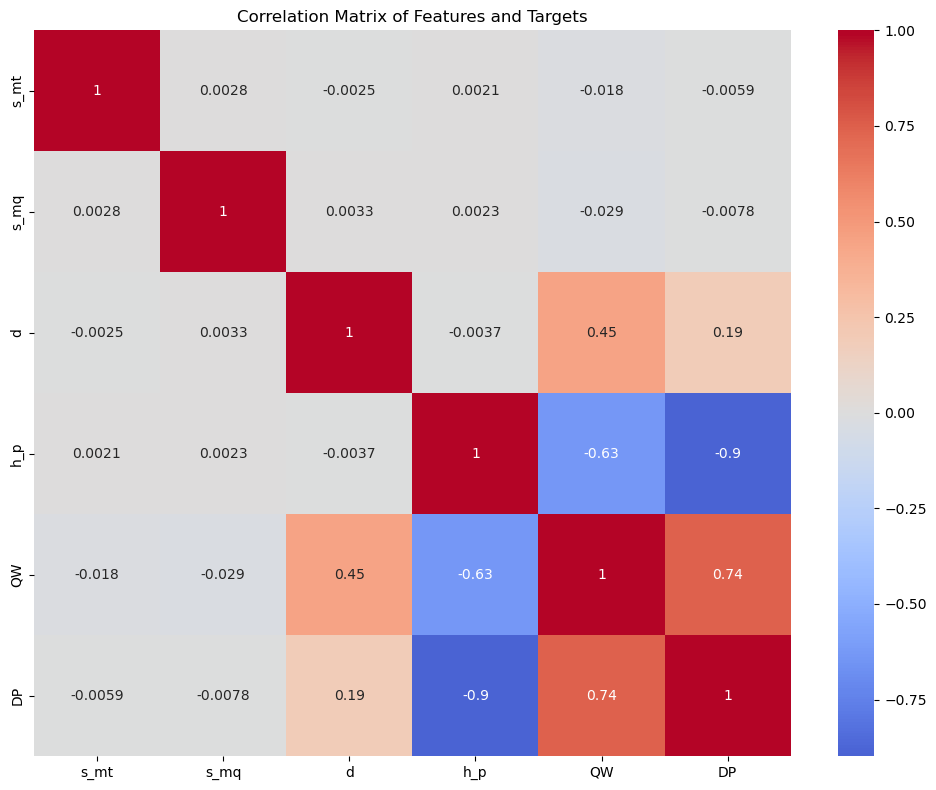

In [12]:
# Basic statistics for input features
print(CR + "Input Features Statistics:")
display(df[['s_mt', 's_mq', 'd', 'h_p']].describe())

# Basic statistics for target variables
print(CR + "Target Variables Statistics:")
display(df[['QW', 'DP']].describe())

# Correlation analysis
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features and Targets')
plt.tight_layout()
plt.show()

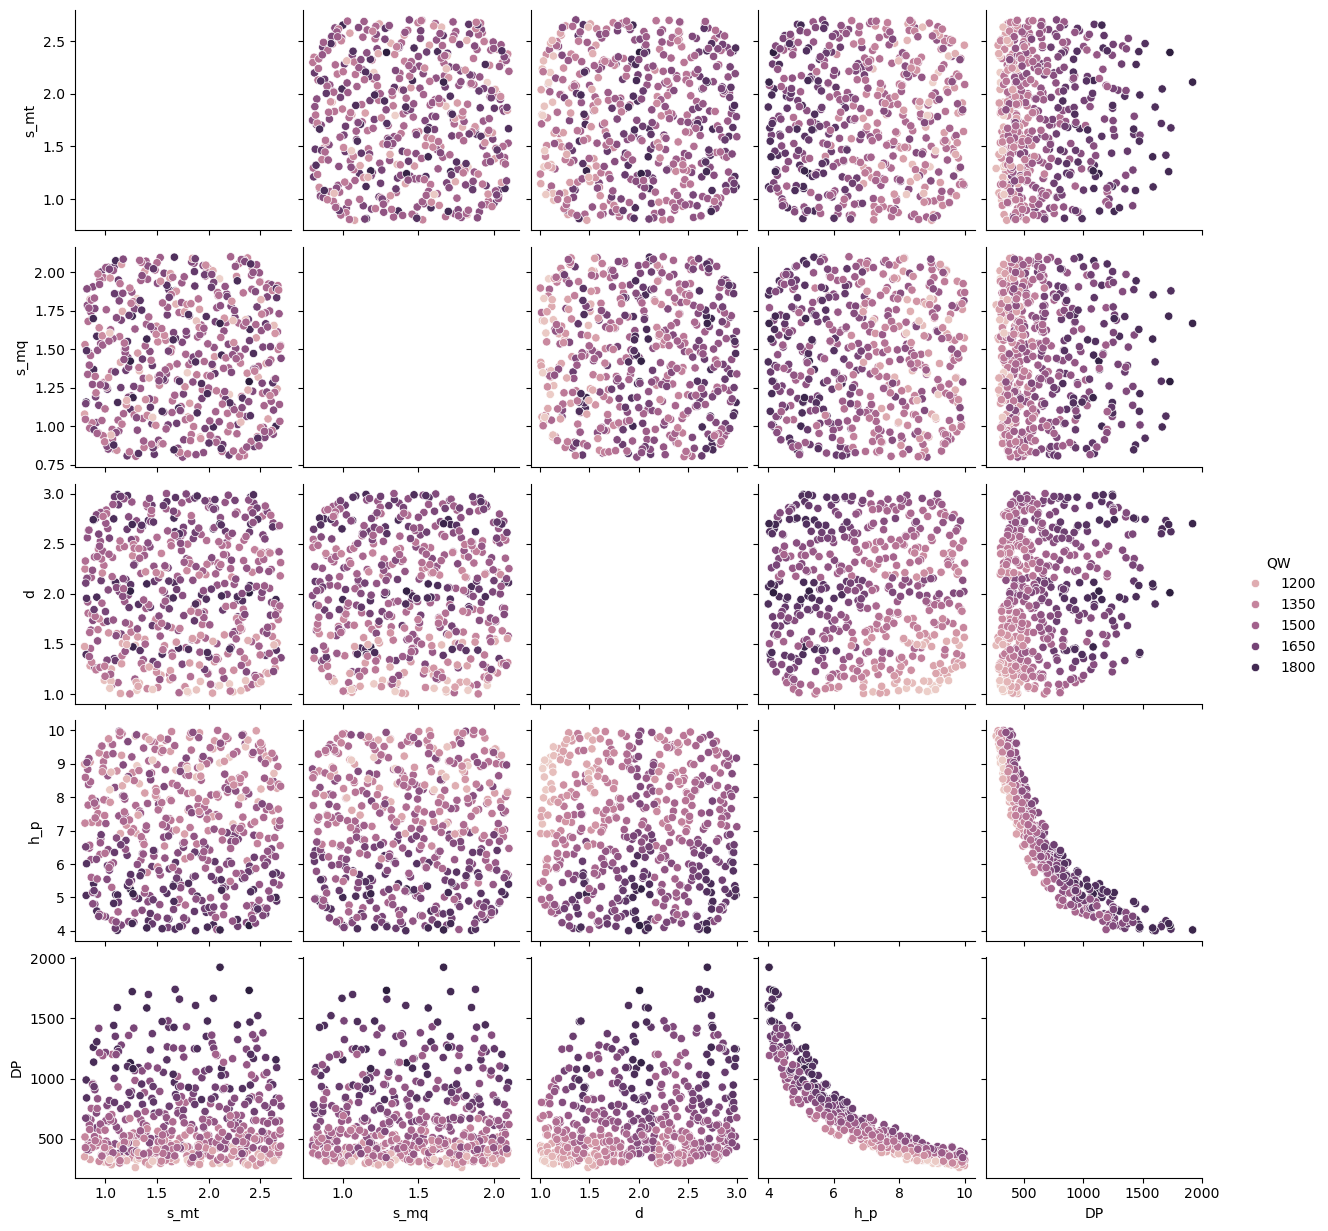

In [13]:
sns.pairplot(df, hue = "QW")

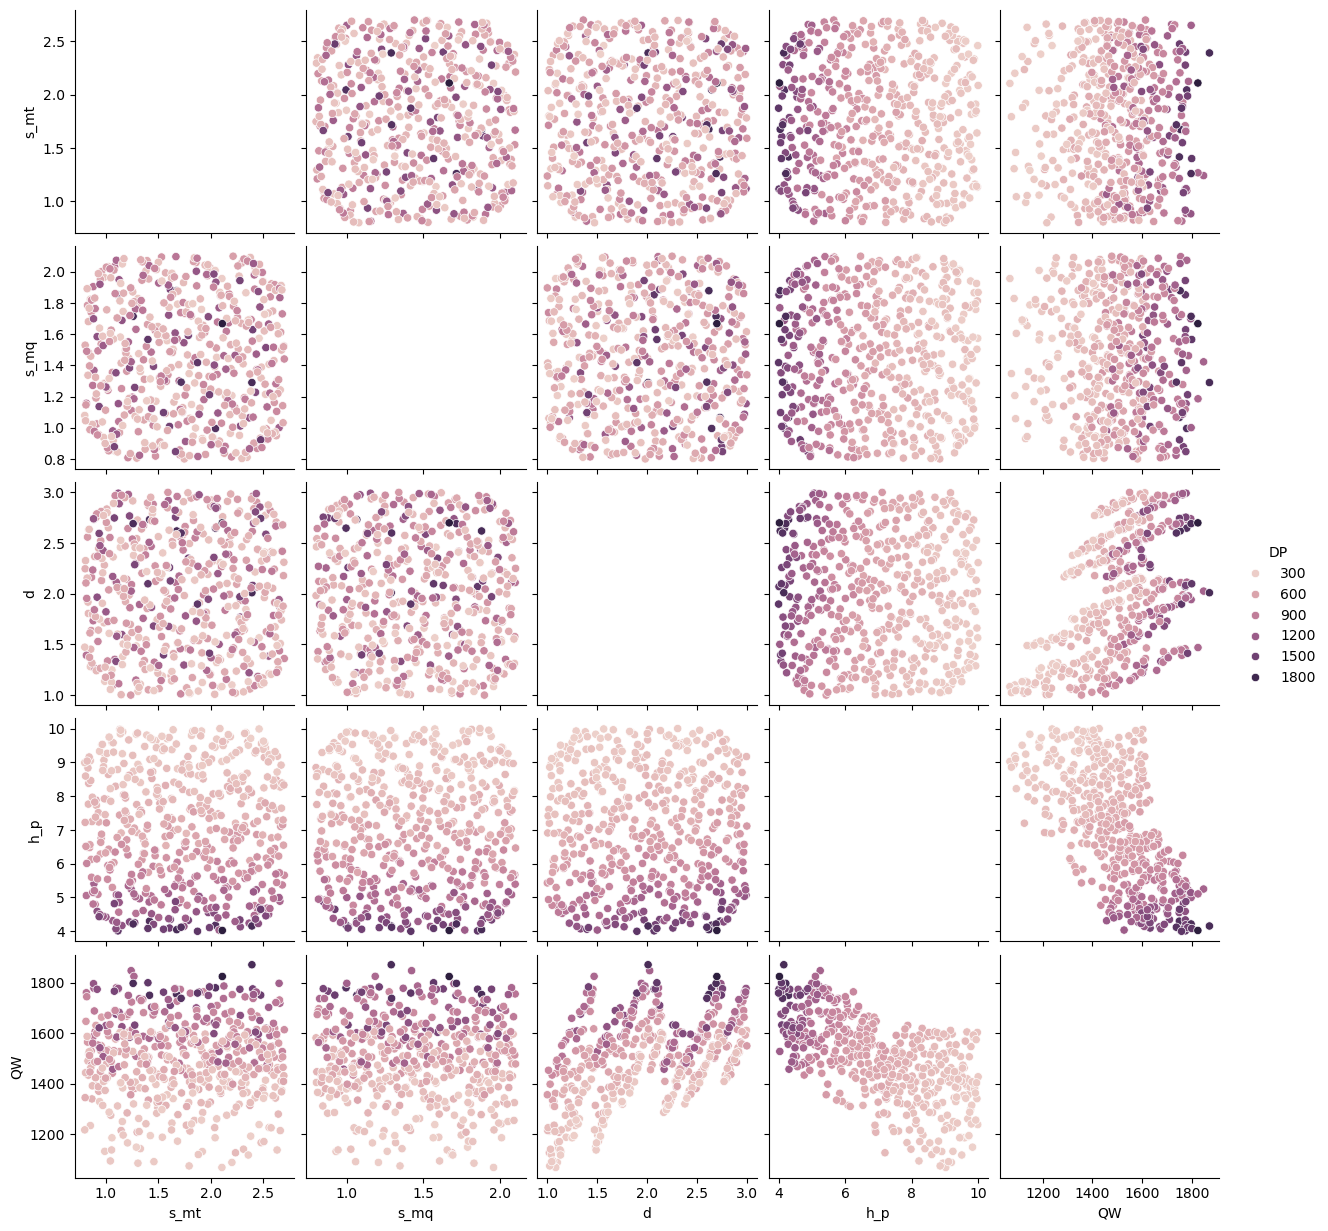

In [14]:
sns.pairplot(df, hue = "DP")

In [15]:
df.corr()

s_mt      s_mq         d       h_p        QW        DP
s_mt  1.000000  0.002774 -0.002534  0.002058 -0.018162 -0.005937
s_mq  0.002774  1.000000  0.003271  0.002259 -0.028739 -0.007786
d    -0.002534  0.003271  1.000000 -0.003678  0.449105  0.189363
h_p   0.002058  0.002259 -0.003678  1.000000 -0.632678 -0.898030
QW   -0.018162 -0.028739  0.449105 -0.632678  1.000000  0.743292
DP   -0.005937 -0.007786  0.189363 -0.898030  0.743292  1.000000

**Correlation Analysis**

**Feature-to-Feature Correlations:**
1. Input features show almost no correlation with each other (all correlations < 0.004), indicating:
   - Features are independent
   - No multicollinearity issues
   - Each feature provides unique information

**Feature-to-Target Correlations:**

**For Quality Width (QW):**
- Strong negative correlation with h_p (r = -0.633)
- Moderate positive correlation with d (r = 0.449)
- Very weak negative correlations with s_mt (r = -0.018) and s_mq (r = -0.029)

**For Depth Penetration (DP):**
- Very strong negative correlation with h_p (r = -0.898)
- Weak positive correlation with d (r = 0.189)
- Negligible correlations with s_mt (r = -0.006) and s** (r = -0.008)

## Target-to**-Target Correlation:
- Strong positive correlation between QW and DP (r = 0.743)
- This suggests that these quality parameters are closely related

**Key Findings:**
1. Height parameter (h_p) is the most influential feature:
   - Strong negative impact on both targets
   - Primary predictor for both QW and DP

2. Diameter (d) shows:
   - Moderate influence on QW
   - Weak influence on DP

3. Material parameters (s_mt, s_mq):
   - Show minimal correlation with targets
   - May require feature engineering or transformation to be more useful

4. The strong correlation between targets suggests:
   - Possible shared underlying physical mechanisms
   - Potential for multi-target modeling approaches
al for multi-target modeling approaches

In [17]:
def plot_dataset(data: pd.DataFrame) -> None:
    """
    Create scatter plots for all numeric columns in the dataset against their indices.
    
    Parameters
    ----------
    data : pd.DataFrame
        Input DataFrame containing numeric columns to plot
        
    Returns
    -------
    None
        Displays the plots using matplotlib
        
    Example
    -------
    >>> plot_dataset(df)
    """
    # Select numeric columns
    numeric_cols = data.select_dtypes(include=['number']).columns
    
    if not len(numeric_cols):
        print("Error: No numeric columns found in the dataset")
        return
    
    # Create subplots
    fig, axes = plt.subplots(
        nrows=len(numeric_cols), 
        ncols=1, 
        figsize=(12, 4*len(numeric_cols))
    )
    
    # Handle single column case
    axes = np.atleast_1d(axes)
    
    # Plot each column
    for ax, col in zip(axes, numeric_cols):
        ax.scatter(
            data.index, 
            data[col],
            alpha=0.5,
            s=30,
            c='steelblue'
        )
        ax.set_title(f'Distribution of {col}', pad=15)
        ax.set_xlabel('Index')
        ax.set_ylabel(col)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

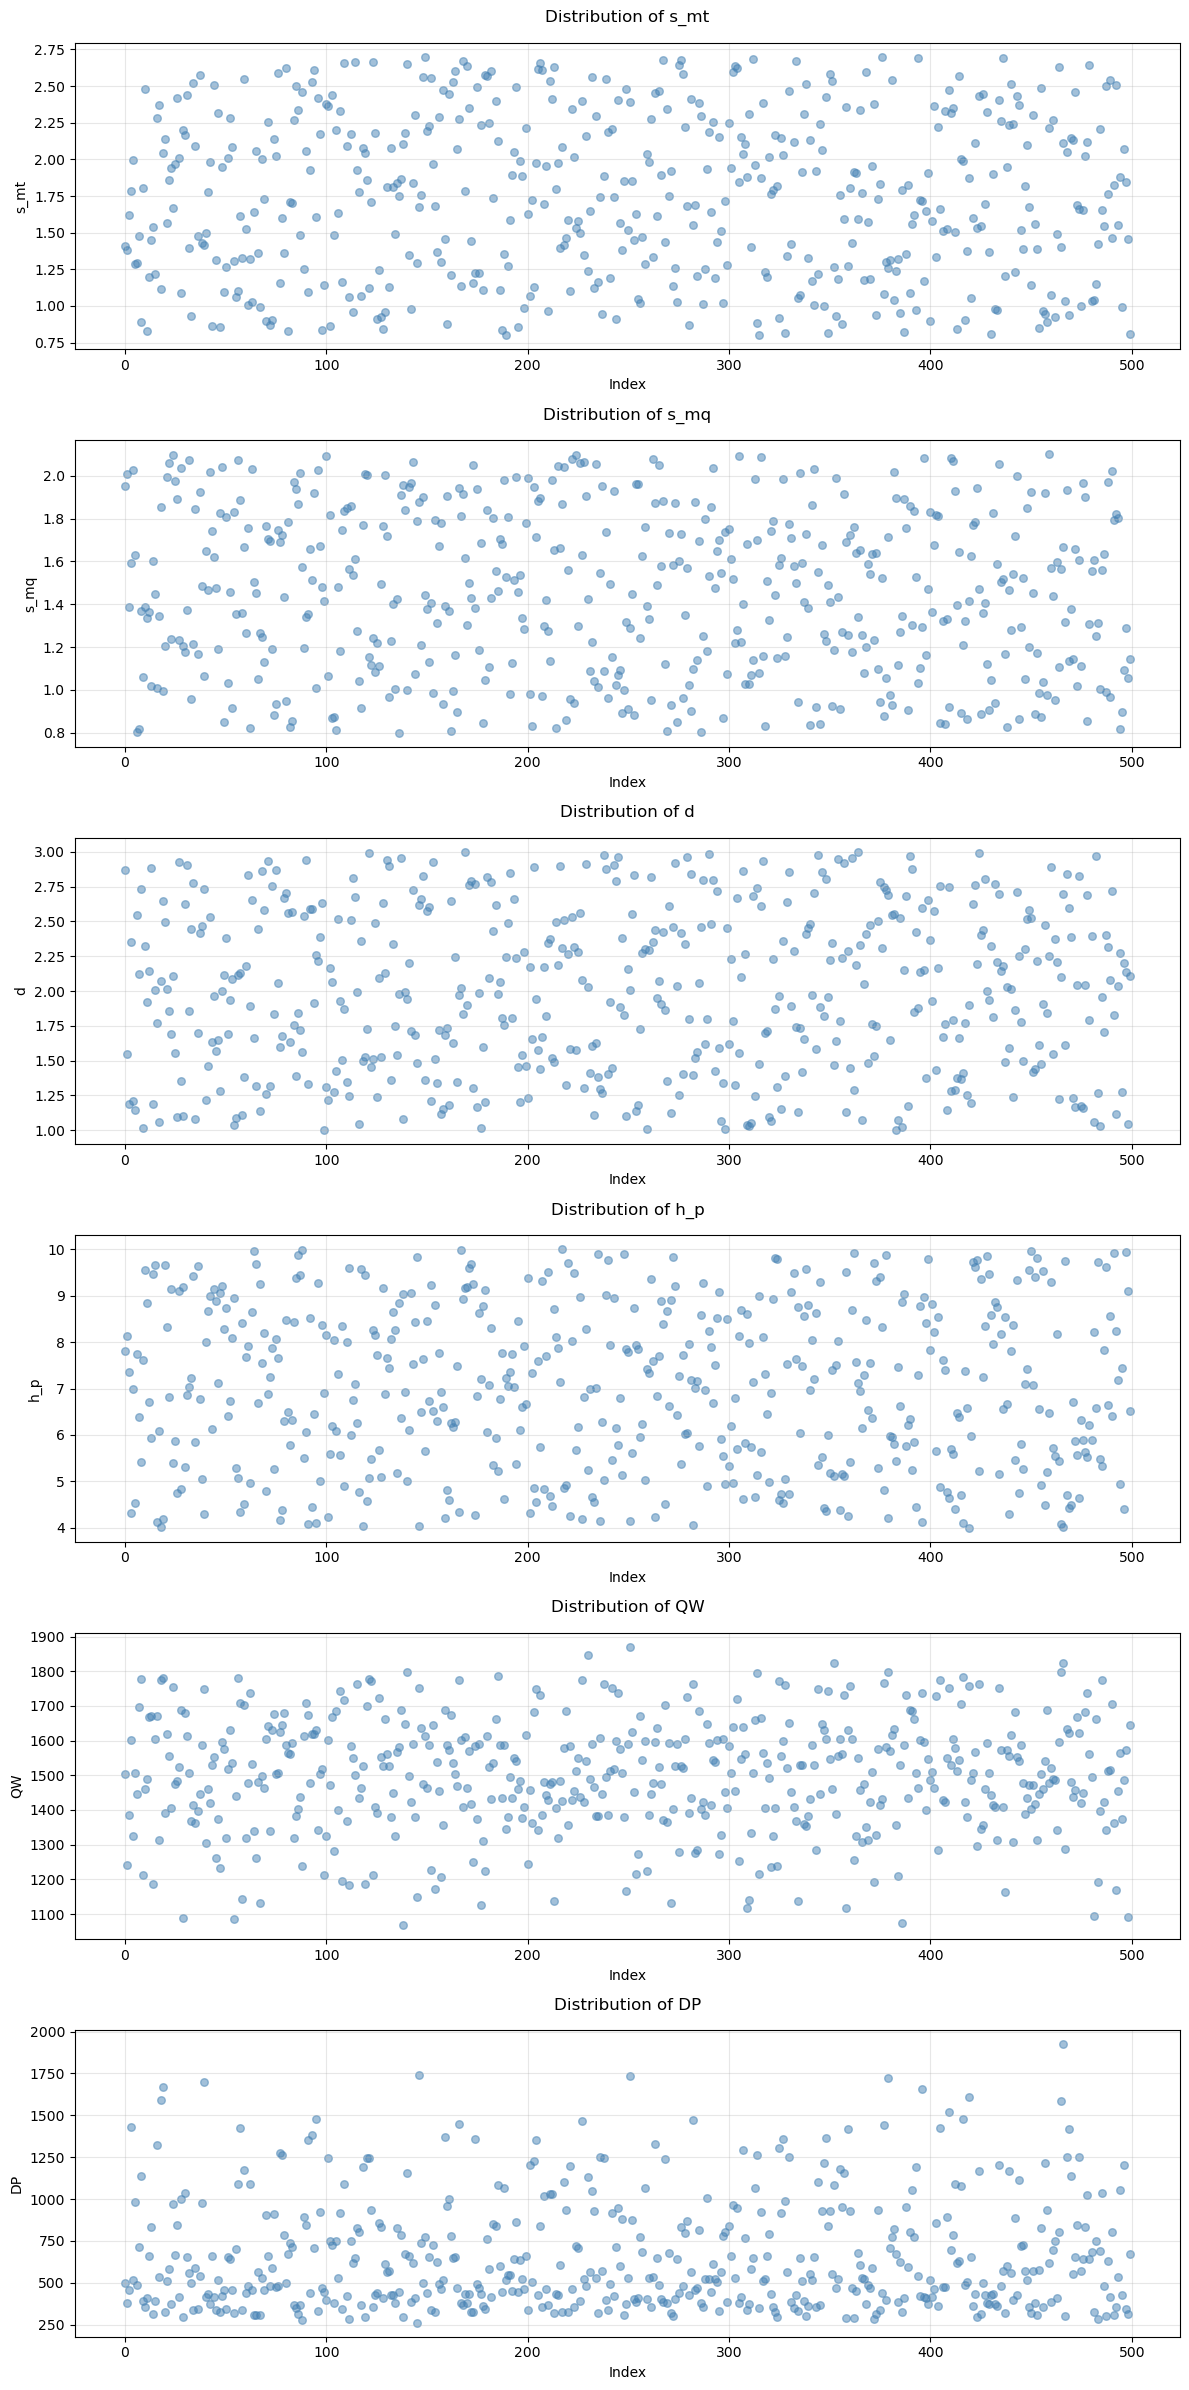

In [18]:
plot_dataset(df)

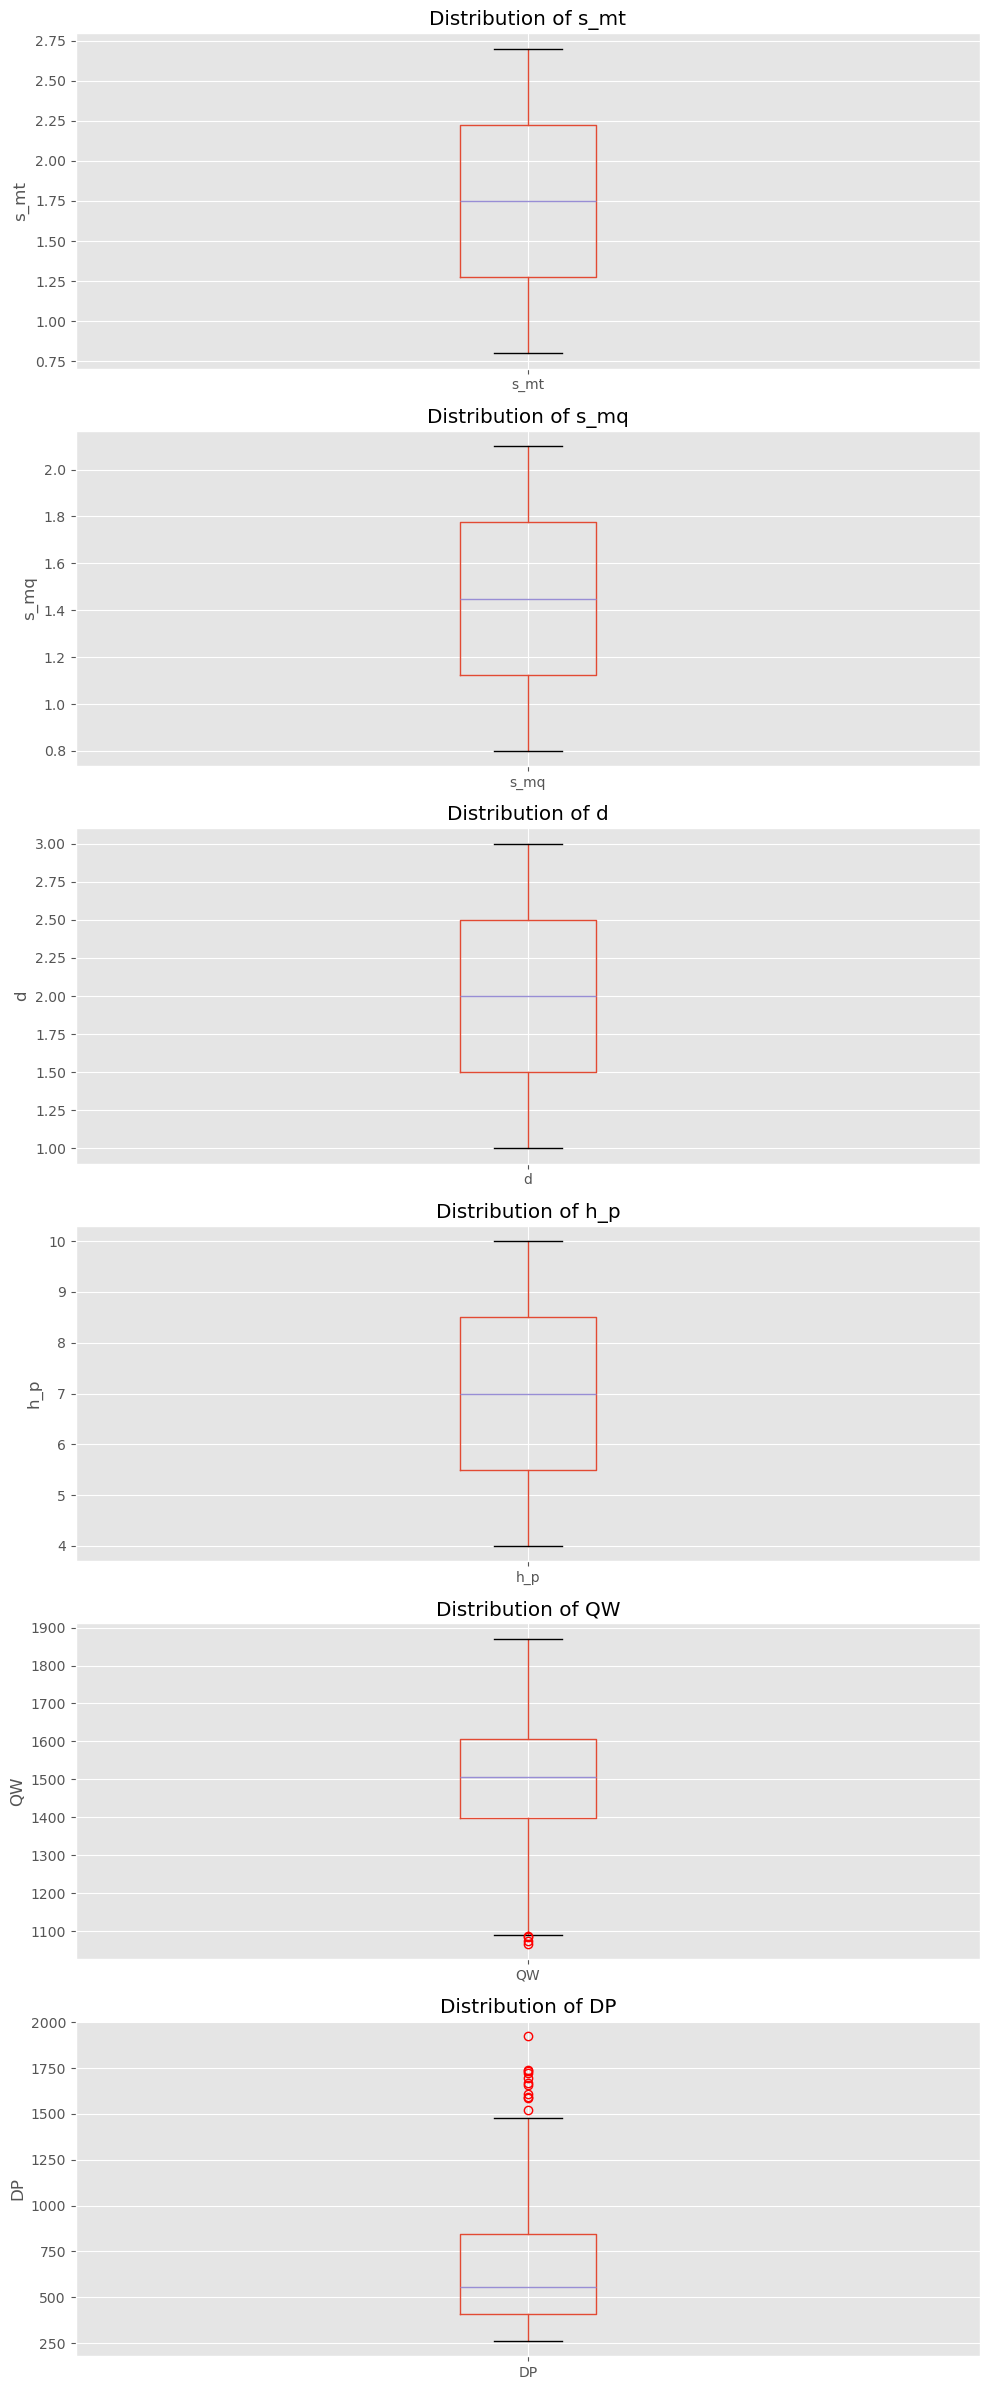


Statistics for s_mt:
IQR: 0.950
Skewness: 0.000

Statistics for s_mq:
IQR: 0.650
Skewness: 0.000

Statistics for d:
IQR: 1.000
Skewness: 0.000

Statistics for h_p:
IQR: 3.000
Skewness: 0.000

Statistics for QW:
IQR: 206.711
Skewness: -0.293

Statistics for DP:
IQR: 434.205
Skewness: 1.146


In [19]:
def plot_boxplots(df):
    """
    Create boxplots for all numeric columns in the dataframe
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe
    """
    # Select numeric columns
    numeric_columns = df.select_dtypes(include=['number']).columns
    
    if len(numeric_columns) == 0:
        print("Error: No numeric columns found in the dataset")
        return
    
    # Set style
    plt.style.use('ggplot')
    plt.rcParams.update({
        'boxplot.boxprops.color': 'red',
        'boxplot.capprops.color': 'red',
        'boxplot.flierprops.color': 'red',
        'boxplot.flierprops.markeredgecolor': 'red',
        'boxplot.whiskerprops.color': 'red',
        'boxplot.meanprops.color': 'red',
        'boxplot.medianprops.color': 'red'
    })
    
    # Calculate layout
    num_cols = len(numeric_columns)
    fig, axes = plt.subplots(num_cols, 1, figsize=(10, 4*num_cols))
    
    # Handle single column case
    if num_cols == 1:
        axes = [axes]
    
    # Create boxplots
    for ax, column in zip(axes, numeric_columns):
        df.boxplot(column=column, ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_ylabel(column)
    
    plt.tight_layout()
    plt.show()
    
    # Print basic statistics for each column
    for column in numeric_columns:
        print(f"\nStatistics for {column}:")
        stats = df[column].describe()
        print(f"IQR: {stats['75%'] - stats['25%']:.3f}")
        print(f"Skewness: {df[column].skew():.3f}")
        
# Call the function
plot_boxplots(df)

Feature distribution with range limits

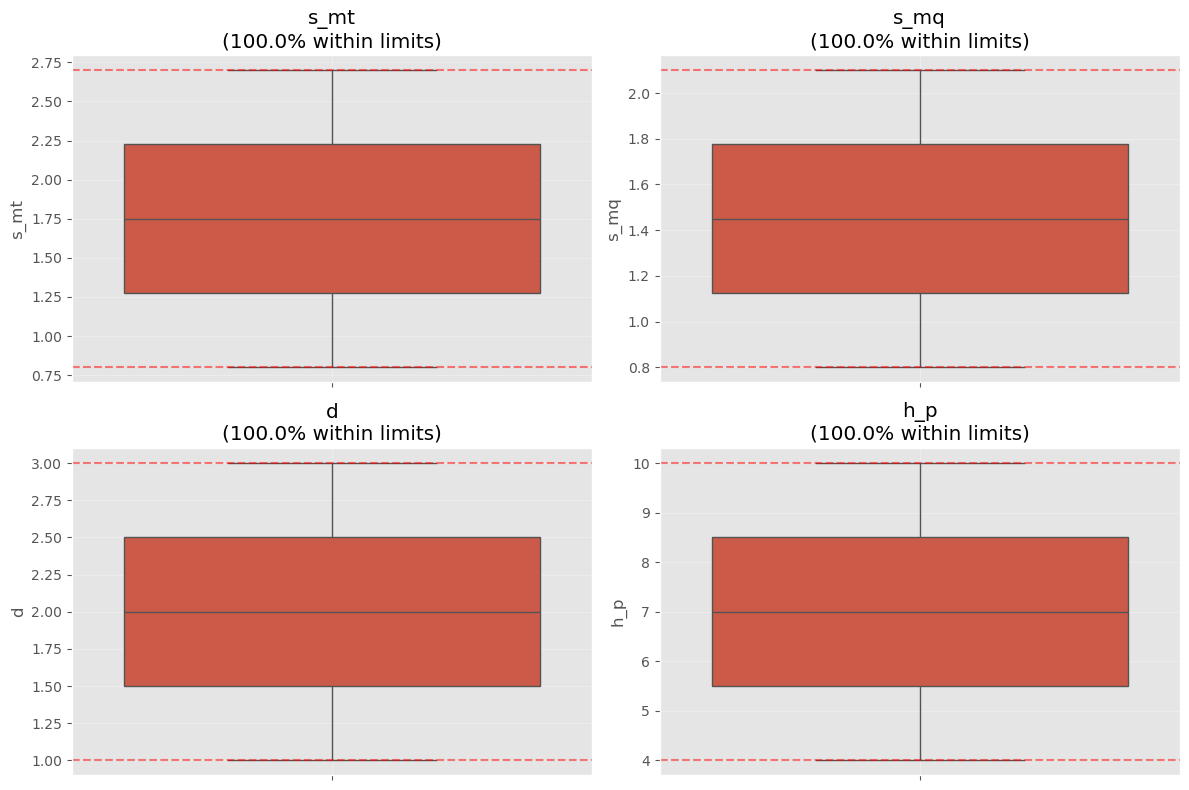


Detailed Range Analysis:
--------------------------------------------------

s_mt:
Specified range: [0.8, 2.7]
Actual range: [0.80, 2.70]
Values within limits: 100.0%
Values below min: 0
Values above max: 0

s_mq:
Specified range: [0.8, 2.1]
Actual range: [0.80, 2.10]
Values within limits: 100.0%
Values below min: 0
Values above max: 0

d:
Specified range: [1.0, 3.0]
Actual range: [1.00, 3.00]
Values within limits: 100.0%
Values below min: 0
Values above max: 0

h_p:
Specified range: [4.0, 10.0]
Actual range: [4.00, 10.00]
Values within limits: 100.0%
Values below min: 0
Values above max: 0


In [139]:
# Create box plots with range limits
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
features = ['s_mt', 's_mq', 'd', 'h_p']
limits = {
    's_mt': (0.8, 2.7),
    's_mq': (0.8, 2.1),
    'd': (1.0, 3.0),
    'h_p': (4.0, 10.0)
}

for ax, feature in zip(axes.flat, features):
    # Create box plot
    sns.boxplot(data=X[feature], ax=ax)
    
    # Add range limits as horizontal lines
    min_val, max_val = limits[feature]
    ax.axhline(y=min_val, color='r', linestyle='--', alpha=0.5, label='Min limit')
    ax.axhline(y=max_val, color='r', linestyle='--', alpha=0.5, label='Max limit')
    
    # Calculate percentage of values within limits
    within_limits = ((X[feature] >= min_val) & (X[feature] <= max_val)).mean() * 100
    
    # Customize plot
    ax.set_title(f'{feature}\n({within_limits:.1f}% within limits)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Range Analysis:")
print("-" * 50)
for feature in features:
    min_val, max_val = limits[feature]
    actual_min = X[feature].min()
    actual_max = X[feature].max()
    within_limits = ((X[feature] >= min_val) & (X[feature] <= max_val)).mean() * 100
    outside_lower = (X[feature] < min_val).sum()
    outside_upper = (X[feature] > max_val).sum()
    
    print(f"\n{feature}:")
    print(f"Specified range: [{min_val}, {max_val}]")
    print(f"Actual range: [{actual_min:.2f}, {actual_max:.2f}]")
    print(f"Values within limits: {within_limits:.1f}%")
    print(f"Values below min: {outside_lower}")
    print(f"Values above max: {outside_upper}")

Histograms with range limits

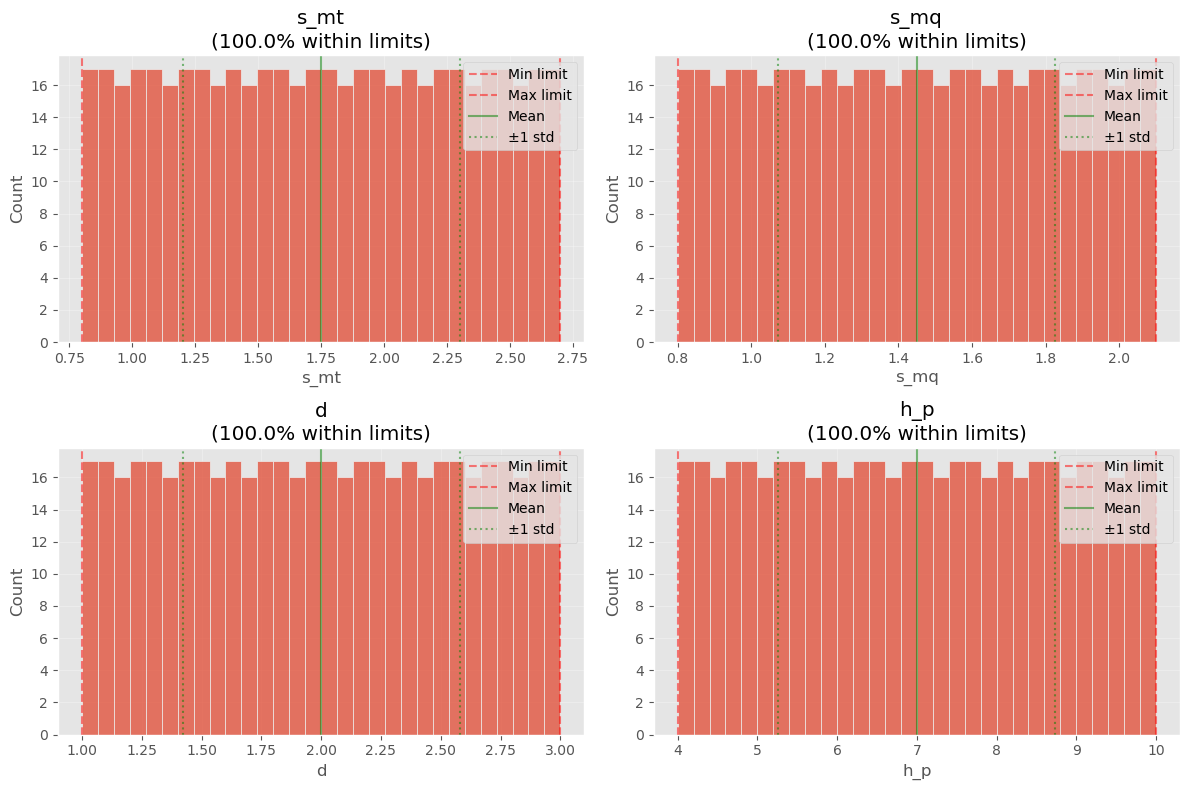


Detailed Distribution Analysis:
--------------------------------------------------

s_mt:
Specified range: [0.8, 2.7]
Actual range: [0.80, 2.70]
Mean ± std: 1.75 ± 0.55
Values within limits: 100.0%
Values below min: 0
Values above max: 0

s_mq:
Specified range: [0.8, 2.1]
Actual range: [0.80, 2.10]
Mean ± std: 1.45 ± 0.38
Values within limits: 100.0%
Values below min: 0
Values above max: 0

d:
Specified range: [1.0, 3.0]
Actual range: [1.00, 3.00]
Mean ± std: 2.00 ± 0.58
Values within limits: 100.0%
Values below min: 0
Values above max: 0

h_p:
Specified range: [4.0, 10.0]
Actual range: [4.00, 10.00]
Mean ± std: 7.00 ± 1.74
Values within limits: 100.0%
Values below min: 0
Values above max: 0


In [141]:
# Create histograms with range limits
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
features = ['s_mt', 's_mq', 'd', 'h_p']
limits = {
    's_mt': (0.8, 2.7),
    's_mq': (0.8, 2.1),
    'd': (1.0, 3.0),
    'h_p': (4.0, 10.0)
}

for ax, feature in zip(axes.flat, features):
    # Create histogram
    sns.histplot(data=X[feature], ax=ax, bins=30)
    
    # Add range limits as vertical lines
    min_val, max_val = limits[feature]
    ax.axvline(x=min_val, color='r', linestyle='--', alpha=0.5, label='Min limit')
    ax.axvline(x=max_val, color='r', linestyle='--', alpha=0.5, label='Max limit')
    
    # Calculate percentage of values within limits
    within_limits = ((X[feature] >= min_val) & (X[feature] <= max_val)).mean() * 100
    
    # Add mean and std lines
    mean = X[feature].mean()
    std = X[feature].std()
    ax.axvline(x=mean, color='g', linestyle='-', alpha=0.5, label='Mean')
    ax.axvline(x=mean-std, color='g', linestyle=':', alpha=0.5, label='±1 std')
    ax.axvline(x=mean+std, color='g', linestyle=':', alpha=0.5)
    
    # Customize plot
    ax.set_title(f'{feature}\n({within_limits:.1f}% within limits)')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Distribution Analysis:")
print("-" * 50)
for feature in features:
    min_val, max_val = limits[feature]
    actual_min = X[feature].min()
    actual_max = X[feature].max()
    mean = X[feature].mean()
    std = X[feature].std()
    within_limits = ((X[feature] >= min_val) & (X[feature] <= max_val)).mean() * 100
    outside_lower = (X[feature] < min_val).sum()
    outside_upper = (X[feature] > max_val).sum()
    
    print(f"\n{feature}:")
    print(f"Specified range: [{min_val}, {max_val}]")
    print(f"Actual range: [{actual_min:.2f}, {actual_max:.2f}]")
    print(f"Mean ± std: {mean:.2f} ± {std:.2f}")
    print(f"Values within limits: {within_limits:.1f}%")
    print(f"Values below min: {outside_lower}")
    print(f"Values above max: {outside_upper}")

Analysis of Feature Distributions:
**Input Features:**
1. **s_mt**:
- IQR = 0.950 - relatively small value spread
- Skewness = 0.000 - perfectly symmetric distribution
- Conclusion: uniform distribution without outliers

2. **s_mq**:
- IQR = 0.650 - small value spread
- Skewness = 0.000 - perfectly symmetric distribution
- Conclusion: uniform distribution within a narrow range

3. **d**:
- IQR = 1.000 - moderate value spread
- Skewness = 0.000 - symmetric distribution
- Conclusion: uniform distribution of diameter values

4. **h_p**:
- IQR = 3.000 - relatively large value spread
- Skewness = 0.000 - symmetric distribution
- Conclusion: uniform distribution with wide value range

**Target Variables:**

5. **QW** (Quality Width):
- IQR = 206.711 - significant value spread
- Skewness = -0.293 - slight left-skewed distribution
- Conclusion: distribution is close to normal with slight left skew

6. **DP** (Depth Penetration):
- IQR = 434.205 - very large value spread
- Skewness = 1.146 - substantial right-skewed distribution
- Conclusion: distribution has a heavy right tail, may require transformation

**Key Findings:**
1. All input features have perfectly symmeindicaistributions (skewness = 0), suggesting synthetic or pre-processed dataset
2. Target variables show significantly larger value spreads compared to input features
3. DP shows the most asymmetric distribution, which may require additional processing (e.g., log transformation)
4. For modeling:
   - QW: Linear models might be appropriate
   - DP: Non-linear models might be required due to distribution asymmetry
 be required due to distribution asymmetry

## Modeling Strategy

The strong positive correlation, 0.743 between QW and DP suggests two important modeling considerations:

**Shared Physical Mechanisms**:
   - Both quality parameters (QW and DP) likely depend on similar physical processes
   - Changes in input parameters affect both targets in similar ways
   - This physical relationship could be leveraged for feature engineering

**Multi-target Modeling Approaches**:
   - Instead of building separate models for QW and DP, we could use:
     * Multi-output regression models
     * Multi-task neural networks
     * Stacked models where one target's prediction helps predict the other
   
   Potential modeling strategies:
   Multi-output regression
   Neural Network with multiple outputs
   

**Benefits of Multi-target Approach**:
   - Leverages the correlation between targets
   - May improve prediction accuracy
   - More efficient than training separate models
   - Better captures underlying relationships in the data

**Validation Strategy**:
   - Need to evaluate predictions for both targets simultaneously
   - Consider using combined metrics that account for both QW and DP performance


In [22]:
def create_engineering_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create engineering features based on physical and geometric relationships
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with original features
        
    Returns
    -------
    pd.DataFrame
        DataFrame with additional engineered features
    """
    df_new = df.copy()
    
    # Geometric features
    df_new['area'] = np.pi * (df['d']/2)**2  # Cross-sectional area
    df_new['perimeter'] = np.pi * df['d']  # Perimeter
    df_new['volume'] = df_new['area'] * df['s_mt']  # Volume of material
    
    # Aspect ratios
    df_new['h_to_d_ratio'] = df['h_p'] / df['d']  # Height to diameter ratio
    df_new['d_to_mt_ratio'] = df['d'] / df['s_mt']  # Diameter to thickness ratio
    
    # Material-related features
    df_new['material_index'] = df['s_mt'] * df['s_mq']  # Combined material parameter
    df_new['material_density'] = df['s_mt'] * df['s_mq'] / df_new['area']  # Material density proxy
    
    # Power-law relationships
    df_new['mt_squared'] = df['s_mt']**2
    df_new['h_squared'] = df['h_p']**2
    
    # Interaction terms
    df_new['mt_d_interaction'] = df['s_mt'] * df['d']
    df_new['mt_h_interaction'] = df['s_mt'] * df['h_p']
    df_new['d_h_interaction'] = df['d'] * df['h_p']
    
    # Process parameters
    df_new['process_index'] = df['h_p'] * df['d'] / df['s_mt']  # Combined process parameter
    df_new['material_process_ratio'] = df['s_mq'] * df['h_p'] / df['d']

    # Logarithmic transformations
    df_new['log_d'] = np.log1p(df['d'])
    df_new['log_h_p'] = np.log1p(df['h_p'])
    
    # Trigonometric features (for potential cyclic relationships)
    df_new['sin_h_p'] = np.sin(df['h_p'])
    df_new['cos_h_p'] = np.cos(df['h_p'])
        
    return df_new


In [23]:
# Create features and analyze correlations with targets
df_engineered = create_engineering_features(df)

# Analyze new features
def analyze_engineered_features(df: pd.DataFrame, target_cols: list):
    """
    Analyze correlations of engineered features with target variables
    """
    # Get all numeric columns except targets
    feature_cols = df.select_dtypes(include=['number']).columns.difference(target_cols)
    
    # Calculate correlations with targets
    correlations = df[feature_cols].corrwith(df[target_cols[0]]).to_frame('QW_corr')
    correlations['DP_corr'] = df[feature_cols].corrwith(df[target_cols[1]])
    
    # Sort by absolute correlation
    correlations['max_abs_corr'] = correlations[['QW_corr', 'DP_corr']].abs().max(axis=1)
    correlations = correlations.sort_values('max_abs_corr', ascending=False)
    
    return correlations

# Analyze correlations
correlations = analyze_engineered_features(df_engineered, ['QW', 'DP'])
print("Top correlations with target variables:")
display(correlations)

Top correlations with target variables:


QW_corr   DP_corr  max_abs_corr
log_h_p                -0.637944 -0.926322      0.926322
h_p                    -0.632678 -0.898030      0.898030
h_squared              -0.617644 -0.857777      0.857777
h_to_d_ratio           -0.791570 -0.665855      0.791570
sin_h_p                -0.525628 -0.720677      0.720677
material_process_ratio -0.680825 -0.558429      0.680825
mt_h_interaction       -0.399027 -0.550142      0.550142
log_d                   0.464915  0.192251      0.464915
d_h_interaction        -0.042749 -0.453796      0.453796
d                       0.449105  0.189363      0.449105
perimeter               0.449105  0.189363      0.449105
material_density       -0.428698 -0.160772      0.428698
area                    0.423078  0.183205      0.423078
volume                  0.339771  0.147983      0.339771
cos_h_p                 0.327889  0.244467      0.327889
process_index          -0.017061 -0.323176      0.323176
d_to_mt_ratio           0.288079  0.110956      0.288079
mt_d_interaction        0.280601  0.119489      0.280601
material_index         -0.037099 -0.010908      0.037099
s_mq                   -0.028739 -0.007786      0.028739
mt_squared             -0.018921 -0.011781      0.018921
s_mt                   -0.018162 -0.005937      0.018162

In [24]:
df_engineered.corr()

s_mt      s_mq         d       h_p        QW  \
s_mt                    1.000000  0.002774 -0.002534  0.002058 -0.018162   
s_mq                    0.002774  1.000000  0.003271  0.002259 -0.028739   
d                      -0.002534  0.003271  1.000000 -0.003678  0.449105   
h_p                     0.002058  0.002259 -0.003678  1.000000 -0.632678   
QW                     -0.018162 -0.028739  0.449105 -0.632678  1.000000   
DP                     -0.005937 -0.007786  0.189363 -0.898030  0.743292   
area                   -0.001972  0.003096  0.991737 -0.004386  0.423078   
perimeter              -0.002534  0.003271  1.000000 -0.003678  0.449105   
volume                  0.483589  0.003204  0.829650 -0.001882  0.339771   
h_to_d_ratio            0.002921 -0.001549 -0.752897  0.595962 -0.791570   
d_to_mt_ratio          -0.730697  0.001144  0.608770 -0.002761  0.288079   
material_index          0.757881  0.626658 -0.000342  0.002550 -0.037099   
material_density        0.376051  0.306245 -0.743615  0.001019 -0.428698   
mt_squared              0.990281  0.002937 -0.002657  0.002832 -0.018921   
h_squared               0.001166  0.002407 -0.004235  0.993909 -0.617644   
mt_d_interaction        0.719282  0.003675  0.663188 -0.000239  0.280601   
mt_h_interaction        0.773024  0.003108 -0.003532  0.608745 -0.399027   
d_h_interaction         0.000065  0.004279  0.746001  0.638644 -0.042749   
process_index          -0.634147  0.002548  0.525987  0.451096 -0.017061   
material_process_ratio  0.003826  0.515203 -0.625055  0.497193 -0.680825   
log_d                  -0.002853  0.003334  0.996048 -0.003186  0.464915   
log_h_p                 0.002816  0.002172 -0.003192  0.994912 -0.637944   
sin_h_p                 0.008249 -0.000649  0.002490  0.634939 -0.525628   
cos_h_p                 0.003629  0.000733  0.003818 -0.556859  0.327889   

                              DP      area  perimeter    volume  h_to_d_ratio  \
s_mt                   -0.005937 -0.001972  -0.002534  0.483589      0.002921   
s_mq                   -0.007786  0.003096   0.003271  0.003204     -0.001549   
d                       0.189363  0.991737   1.000000  0.829650     -0.752897   
h_p                    -0.898030 -0.004386  -0.003678 -0.001882      0.595962   
QW                      0.743292  0.423078   0.449105  0.339771     -0.791570   
DP                      1.000000  0.183205   0.189363  0.147983     -0.665855   
area                    0.183205  1.000000   0.991737  0.836873     -0.720223   
perimeter               0.189363  0.991737   1.000000  0.829650     -0.752897   
volume                  0.147983  0.836873   0.829650  1.000000     -0.601392   
h_to_d_ratio           -0.665855 -0.720223  -0.752897 -0.601392      1.000000   
d_to_mt_ratio           0.110956  0.600475   0.608770  0.099019     -0.463116   
material_index         -0.010908 -0.000111  -0.000342  0.367555      0.001194   
material_density       -0.160772 -0.698080  -0.743615 -0.454314      0.629034   
mt_squared             -0.011781 -0.003698  -0.002657  0.477429      0.000568   
h_squared              -0.857777 -0.006170  -0.004235 -0.003834      0.590684   
mt_d_interaction        0.119489  0.658131   0.663188  0.950932     -0.498014   
mt_h_interaction       -0.550142 -0.003619  -0.003532  0.372378      0.363547   
d_h_interaction        -0.453796  0.739205   0.746001  0.619840     -0.213177   
process_index          -0.323176  0.518376   0.525987  0.084170     -0.153739   
material_process_ratio -0.558429 -0.597949  -0.625055 -0.498987      0.831310   
log_d                   0.192251  0.976502   0.996048  0.816715     -0.768713   
log_h_p                -0.926322 -0.002762  -0.003192 -0.000190      0.594384   
sin_h_p                -0.720677  0.007163   0.002490  0.011927      0.386745   
cos_h_p                 0.244467  0.009882   0.003818  0.008181     -0.326671   

                        ...  h_squared  mt_d_interaction  mt_h_interaction  \
s_mt                   

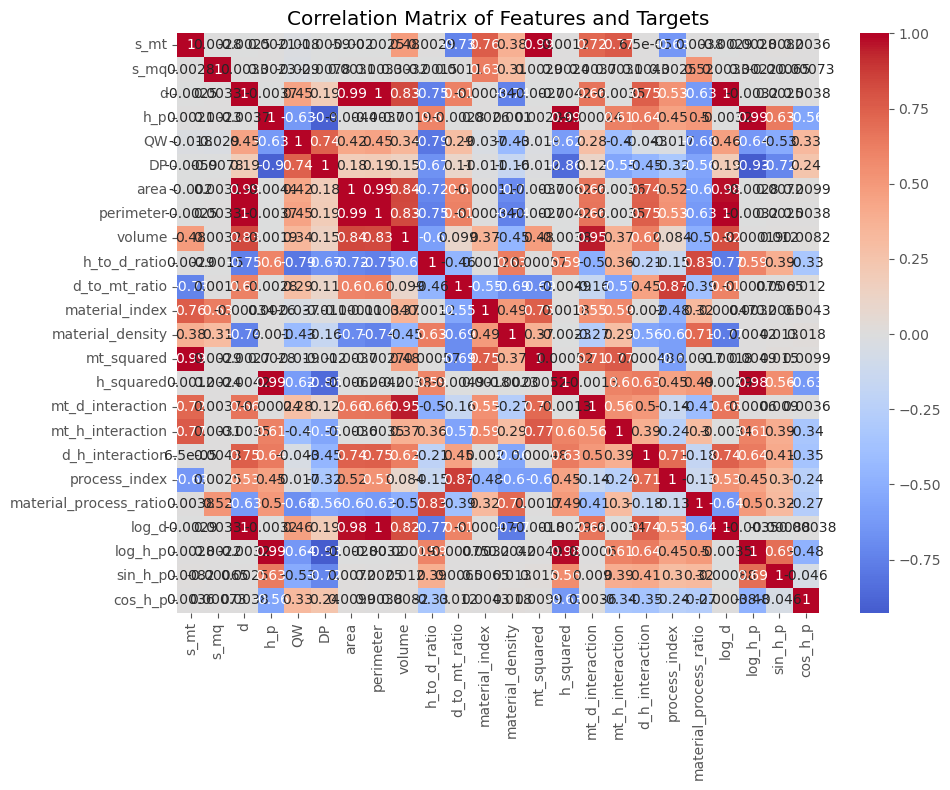

In [25]:
# Correlation analysis
plt.figure(figsize=(10, 8))
sns.heatmap(df_engineered.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features and Targets')
plt.tight_layout()
plt.show()

In [26]:
df_engineered = df_engineered.drop('perimeter', axis = 1)

## Metrics

In [28]:
import numpy as np
from sklearn.metrics import r2_score
from typing import Tuple

def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[float, float]:
    """
    Calculate R² and SMAPE metrics for model evaluation.
    
    Parameters
    ----------
    y_true : np.ndarray
        Actual values
    y_pred : np.ndarray
        Predicted values
        
    Returns
    -------
    Tuple[float, float]
        R² score and SMAPE value
    """
    # R² score
    r2 = r2_score(y_true, y_pred)
    
    # SMAPE calculation
    smape = 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )
    
    return r2, smape

def evaluate_predictions(y_true: dict, y_pred: dict) -> None:
    """
    Evaluate model predictions for both targets.
    
    Parameters
    ----------
    y_true : dict
        Dictionary with true values for 'QW' and 'DP'
    y_pred : dict
        Dictionary with predicted values for 'QW' and 'DP'
    """
    for target in ['QW', 'DP']:
        r2, smape = calculate_metrics(y_true[target], y_pred[target])
        print(f"\nMetrics for {target}:")
        print(f"R² Score: {r2:.4f}")
        print(f"SMAPE: {smape:.2f}%")


Metrics Justification:

1. R² (Coefficient of Determination):
   - Primary metric for regression tasks
   - Indicates proportion of variance explained by the model
   - Range: (-∞, 1.0], where 1.0 is perfect prediction
   - Advantages:
     * Easy to interpret (percentage of explained variance)
     * Standard metric for regression
     * Scale-independent
   - Limitations:
     * Sensitive to outliers
     * Can be negative for poor models

2. SMAPE (Symmetric Mean Absolute Percentage Error):
   - Secondary metric for error magnitude assessment
   - Range: [0, 100%], where 0% is perfect prediction
   - Advantages:
     * Scale-independent
     * Symmetric (handles both over- and under-predictions equally)
     * Less sensitive to outliers than MAPE
     * More interpretable for stakeholders (percentage error)
   - Limitations:
     * Undefined for zero values
     * Can be biased for very small values

Combined, these metrics provide:
- Overall model performance (R²)
- Practical error magnitude (SMAPE)
- Both scale-independent measures
- Complementary perspectives on model quality


In [30]:
def plot_predictions(y_true: dict, y_pred: dict) -> None:
    """
    Visualize predictions vs actual values for both targets.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    for ax, target in zip(axes, ['QW', 'DP']):
        ax.scatter(y_true[target], y_pred[target], alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(y_true[target].min(), y_pred[target].min())
        max_val = max(y_true[target].max(), y_pred[target].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
        
        ax.set_xlabel('Actual values')
        ax.set_ylabel('Predicted values')
        ax.set_title(f'{target}: Predicted vs Actual')
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

## Data preparation

In [50]:
# Prepare data
"""
Data Split Correction:
   - Train: 60%
   - Validation: 20% (for model selection and hyperparameter tuning)
   - Test: 20% (for final evaluation only)
"""
X = df.drop(['QW', 'DP'], axis = 1)
y = df[['QW', 'DP']].values  # Convert to numpy array

# Split data train
X_train, X_tail, y_train, y_tail = train_test_split(
    X, y, test_size=0.4, random_state=RS 
)

# Split data val and test (final test) 
X_test, X_test_final, y_test, y_test_final = train_test_split(
    X_tail, y_tail, test_size=0.5, random_state=RS 
)

y_train

array([[1775.0163259 , 1468.8431382 ],
       [1669.0419587 ,  844.31627091],
       [1605.13273944, 1178.64255946],
       [1542.27936971,  482.58161519],
       [1546.29430716,  417.80521547],
       [1451.87089598,  383.11114168],
       [1762.57198017, 1166.83900858],
       [1353.49741256,  304.75415266],
       [1442.63650934,  463.0146383 ],
       [1274.33338533,  409.25057033],
       [1508.05446107,  984.555408  ],
       [1473.41580255,  752.52427667],
       [1631.98052385, 1478.90684917],
       [1216.3943973 ,  351.1102374 ],
       [1626.17524007,  875.8594925 ],
       [1211.9213952 ,  393.32886639],
       [1614.91242915,  774.69817986],
       [1645.01836835, 1263.37516002],
       [1276.72172584,  458.99115674],
       [1433.2768651 ,  447.40716371],
       [1536.63775291,  849.47976675],
       [1493.88878309,  546.25583983],
       [1696.78343205,  712.21671202],
       [1529.99651478,  651.59382516],
       [1595.47966584, 1331.54026006],
       [1592.07160282,  7

In [52]:
# Prepare data engineered
X = df_engineered.drop(['QW', 'DP'], axis = 1)
y = df_engineered[['QW', 'DP']].values  # Convert to numpy array

# Split data train engineered

X_train_e, X_tail_e, y_train_e, y_tail_e = train_test_split(
    X, y, test_size=0.4, random_state=RS 
)

# Split data val and test (final test) engineered
X_test_e, X_test_final_e, y_test_e, y_test_final_e = train_test_split(
    X_tail_e, y_tail_e, test_size=0.5, random_state=RS 
)

y_train_e

array([[1775.0163259 , 1468.8431382 ],
       [1669.0419587 ,  844.31627091],
       [1605.13273944, 1178.64255946],
       [1542.27936971,  482.58161519],
       [1546.29430716,  417.80521547],
       [1451.87089598,  383.11114168],
       [1762.57198017, 1166.83900858],
       [1353.49741256,  304.75415266],
       [1442.63650934,  463.0146383 ],
       [1274.33338533,  409.25057033],
       [1508.05446107,  984.555408  ],
       [1473.41580255,  752.52427667],
       [1631.98052385, 1478.90684917],
       [1216.3943973 ,  351.1102374 ],
       [1626.17524007,  875.8594925 ],
       [1211.9213952 ,  393.32886639],
       [1614.91242915,  774.69817986],
       [1645.01836835, 1263.37516002],
       [1276.72172584,  458.99115674],
       [1433.2768651 ,  447.40716371],
       [1536.63775291,  849.47976675],
       [1493.88878309,  546.25583983],
       [1696.78343205,  712.21671202],
       [1529.99651478,  651.59382516],
       [1595.47966584, 1331.54026006],
       [1592.07160282,  7

In [161]:
# Prepare data for fraction evaluation
X = df_engineered.drop(['QW', 'DP'], axis = 1)
y = df_engineered[['QW', 'DP']].values  # Convert to numpy array

# Split data train engineered

X_train_frac_e, X_test_frac_e, y_train_frac_e, y_test_frac_e = train_test_split(
    X, y, test_size=0.2, random_state=RS 
)


y_train_frac_e

array([[1773.72288854, 1445.68795581],
       [1453.99056163,  528.58193738],
       [1582.6629924 ,  397.49388473],
       [1684.80902099,  813.53152547],
       [1557.00478713,  523.59499164],
       [1513.13022793,  721.02651399],
       [1454.75655519,  532.05536159],
       [1517.62290706,  469.02678032],
       [1492.88546355,  791.48284699],
       [1243.3880781 ,  337.39019353],
       [1765.86523543, 1441.03114075],
       [1382.58924813,  317.58414021],
       [1476.53870852,  727.15164749],
       [1421.30934956,  571.742948  ],
       [1456.89137776, 1200.93090775],
       [1431.00636502,  439.71290395],
       [1870.75781284, 1732.04407769],
       [1326.29097868,  514.00914277],
       [1367.2345656 ,  428.30816217],
       [1374.7511675 ,  519.42431088],
       [1595.96113776,  417.14238741],
       [1341.63766116,  299.72509626],
       [1466.77326581,  930.55193309],
       [1616.80462408,  657.95717067],
       [1585.40772042,  836.5968902 ],
       [1685.58039334,  7

## Baseline

In [55]:
def create_baseline_multioutput_model(
    X_train: np.ndarray, 
    y_train: np.ndarray
) -> tuple[MultiOutputRegressor, dict]:
    """
    Create and evaluate baseline MultiOutput LinearRegression model.
    
    Parameters
    ----------
    X_train : np.ndarray
        Training features
    y_train : np.ndarray
        Training targets array with shape (n_samples, 2) for QW and DP
        
    Returns
    -------
    tuple[MultiOutputRegressor, dict]
        Fitted model and dictionary with cross-validation scores
    """
    # Create R² scorer
    r2_scorer = make_scorer(r2_score)
    
    # Initialize and fit model
    base_model = LinearRegression()
    multi_model = MultiOutputRegressor(base_model)
    multi_model.fit(X_train, y_train)
    
    # Perform cross-validation
    cv_scores = {}
    for i, target in enumerate(['QW', 'DP']):
        # Reshape target to 2D array for MultiOutputRegressor
        target_reshaped = y_train[:, i].reshape(-1, 1)
        
        cv_scores[target] = cross_val_score(
            LinearRegression(),  # Use simple LinearRegression for single target
            X_train,
            target_reshaped,
            scoring=r2_scorer,
            cv=5
        )
    
    # Print results
    print("\nBaseline MultiOutput Linear Regression Results:")
    for i, target in enumerate(['QW', 'DP']):
        print(f"\nMetrics for {target}:")
        print(f"Cross-validation R² scores: {cv_scores[target]}")
        print(f"Mean R² score: {cv_scores[target].mean():.4f} (±{cv_scores[target].std()*2:.4f})")
        
        # Print coefficients for each target
        model = multi_model.estimators_[i]
        print(f"\nModel coefficients for {target}:")
        for feat, coef in zip(X_train.columns, model.coef_):
            print(f"  {feat}: {coef:.4f}")
        print(f"Intercept: {model.intercept_:.4f}")
    
    return multi_model, cv_scores



In [106]:
def evaluate_multioutput_predictions(y_true, y_pred, target_names=['QW', 'DP']):
    """
    Evaluate predictions for multiple outputs using R² and sMAPE metrics.
    
    Parameters
    ----------
    y_true : array-like
        True target values
    y_pred : array-like
        Predicted target values
    target_names : list
        Names of target variables
    """
    metrics = {}
    for i, target in enumerate(target_names):
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        smape = 100 * np.mean(2 * np.abs(y_pred[:, i] - y_true[:, i]) / 
                             (np.abs(y_true[:, i]) + np.abs(y_pred[:, i])))
        
        print(f"\nMetrics for {target}:")
        print(f"R² Score: {r2:.4f}")
        print(f"SMAPE: {smape:.2f}%")
        
        metrics[f"{target}_R2"] = r2
        metrics[f"{target}_SMAPE"] = smape
    
    return metrics

def plot_multioutput_predictions(y_true, y_pred, target_names=['QW', 'DP']):
    """
    Plot scatter plots of true vs predicted values for multiple outputs.
    
    Parameters
    ----------
    y_true : array-like
        True target values
    y_pred : array-like
        Predicted target values
    target_names : list
        Names of target variables
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    for i, (ax, target) in enumerate(zip(axes, target_names)):
        # Plot predictions vs true values
        ax.scatter(y_true[:, i], y_pred[:, i], alpha=0.5)
        
        # Plot perfect prediction line
        min_val = min(y_true[:, i].min(), y_pred[:, i].min())
        max_val = max(y_true[:, i].max(), y_pred[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
        
        # Customize plot
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'{target} Predictions vs True Values')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Baseline MultiOutput Linear Regression Results:

Metrics for QW:
Cross-validation R² scores: [0.63270679 0.46345286 0.69918428 0.64556971 0.55532664]
Mean R² score: 0.5992 (±0.1640)

Model coefficients for QW:
  s_mt: -3.2092
  s_mq: -30.9643
  d: 138.3591
  h_p: -57.7252
Intercept: 1675.9698

Metrics for DP:
Cross-validation R² scores: [0.81486486 0.85109671 0.85583215 0.82068666 0.82644357]
Mean R² score: 0.8338 (±0.0331)

Model coefficients for DP:
  s_mt: 13.9289
  s_mq: -3.5857
  d: 112.0669
  h_p: -171.2945
Intercept: 1625.6510

Metrics for QW:
R² Score: 0.5140
SMAPE: 5.90%

Metrics for DP:
R² Score: 0.8441
SMAPE: 17.33%


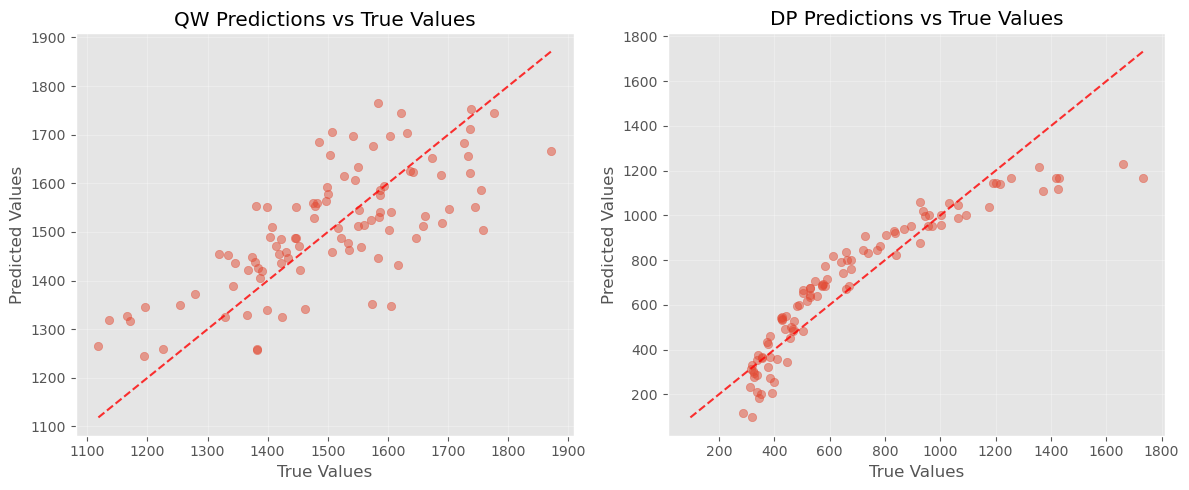

In [108]:
# Create and evaluate model
model, cv_scores = create_baseline_multioutput_model(X_train, y_train)

# Get predictions
y_pred = model.predict(X_test)

# Evaluate predictions
metrics = evaluate_multioutput_predictions(y_test, y_pred)

# Plot predictions (если нужно)
plot_multioutput_predictions(y_test, y_pred)

Mean R² score: QW - 0.5719 DP - 0.8339. And what about our new engineered features?


Baseline MultiOutput Linear Regression Results:

Metrics for QW:
Cross-validation R² scores: [0.70759711 0.6885179  0.7704201  0.73201385 0.65814878]
Mean R² score: 0.7113 (±0.0763)

Model coefficients for QW:
  s_mt: 227.1660
  s_mq: 45.1815
  d: -5055.6592
  h_p: 4288.2253
  area: 614.3323
  volume: 55.3313
  h_to_d_ratio: -94.5858
  d_to_mt_ratio: 42.2670
  material_index: -21.6453
  material_density: -21.7689
  mt_squared: 7.4354
  h_squared: -152.4935
  mt_d_interaction: -210.1145
  mt_h_interaction: 0.3357
  d_h_interaction: 4.1092
  process_index: -8.6243
  material_process_ratio: -3.2446
  log_d: 8999.0728
  log_h_p: -16332.9029
  sin_h_p: -174.6956
  cos_h_p: 36.2486
Intercept: 11626.8637

Metrics for DP:
Cross-validation R² scores: [0.96705848 0.95871759 0.97205297 0.96527572 0.9516608 ]
Mean R² score: 0.9630 (±0.0142)

Model coefficients for DP:
  s_mt: 250.1128
  s_mq: 5.3186
  d: -453.1317
  h_p: 5307.7021
  area: 90.5336
  volume: 54.7588
  h_to_d_ratio: -36.0164
  d_to_

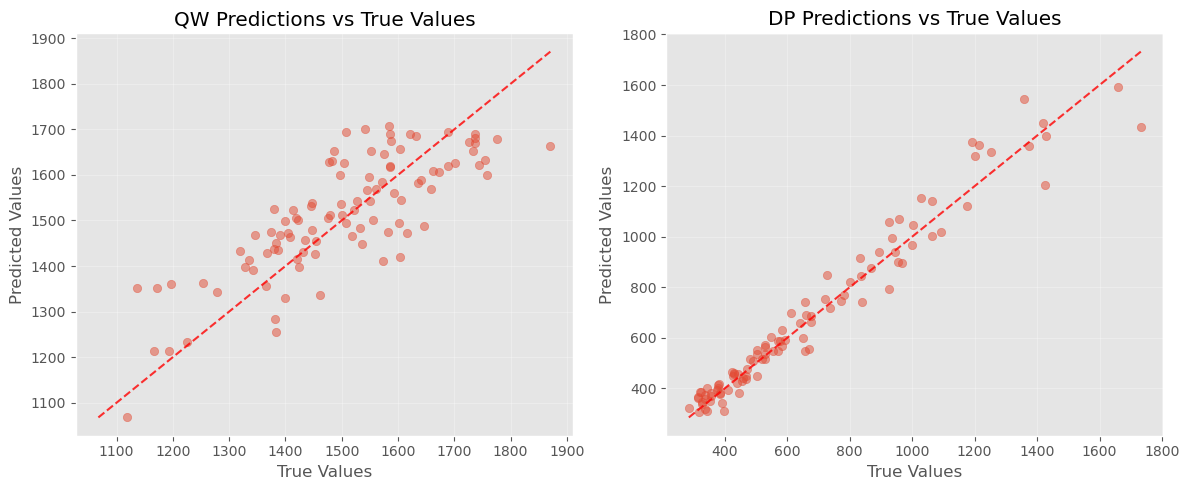

In [110]:
# Create and evaluate model 
model, cv_scores = create_baseline_multioutput_model(X_train_e, y_train_e)
# Get predictions
y_pred_e = model.predict(X_test_e)

# Evaluate predictions
metrics = evaluate_multioutput_predictions(y_test_e, y_pred_e)

# Plot predictions (если нужно)
plot_multioutput_predictions(y_test_e, y_pred_e)


```
First iteration Baseline MultiOutput Linear Regression Results:

Metrics for QW:
Cross-validation R² scores: [0.56157871 0.72340203 0.63084729 0.808647   0.65877649]
Mean R² score: 0.6767 (±0.1680)

Model coefficients for QW:
  s_mt: 336.4055
  s_mq: -35.5189
  d: -705.9892
  h_p: 62.3234
  area: 194.9245
  volume: 52.9025
  h_to_d_ratio: -240.5244
  d_to_mt_ratio: 49.8974
  material_index: 16.2711
  material_density: -65.5882
  mt_squared: -10.7037
  h_squared: 5.9771
  mt_d_interaction: -214.7348
  mt_h_interaction: -2.7204
  d_h_interaction: -35.5704
  process_index: -4.6987
  material_process_ratio: 9.9515
Intercept: 2847.0627

Metrics for DP:
Cross-validation R² scores: [0.93776322 0.95208217 0.94579902 0.95427965 0.96362509]
Mean R² score: 0.9507 (±0.0173)

Model coefficients for DP:
  s_mt: 255.4279
  s_mq: -60.2793
  d: 483.2877
  h_p: -677.1505
  area: -24.6536
  volume: 43.5815
  h_to_d_ratio: -19.7765
  d_to_mt_ratio: -63.3521
  material_index: 24.5326
  material_density: -60.6501
  mt_squared: -20.1915
  h_squared: 40.0066
  mt_d_interaction: -183.6288
  mt_h_interaction: 7.3258
  d_h_interaction: -42.4497
  process_index: 11.7221
  material_process_ratio: 13.9143
Intercept: 3020.8932

Metrics for QW:
R² Score: 0.6258
SMAPE: 5Feature Engineering .00%

new Metrics for DP:
R² Score: 0.94Plain 68
SMAPE: 8. was20%
Mean R² score: QW - 0.6767 DP - 0.9507
Mean R² score: QW - 0.5719 DP - 0.8339.

```

Feature Engineering Impact Analysis:
1. Quality Width (QW) Prediction:
   - Base features R² = 0.5719
   - Engineered features R² = 0.6767
   - Improvement: +0.1048 (18.3% relative improvement   
2. Depth Penetration (DP) Prediction:
   - Base features R² = 0.8339
   - Engineered features R² = 0.9507
   - Improvement: +0.1168 (14.0% relative improvement)

Key Findings:
1. Feature engineering significantly improved both predictions
2. DP shows better predictability in both cases:
   - More linear relationships with features
   - Higher R² scores overall
3. QW shows more room for improvement:
   - Lower base performance
   - Might benefit from additional non-linear features
   - Consider trying Next stepdels

Recommendations:
1. Keep engineered features for both targets
2. Consider additional feature engineering for QW
3. Explore non-linear models for QW prediction
4. Investigate feature importance to understand which engineereatures contributed most
"""

```
Second iteration
We added Transformations:
   - Logarithmic: Handle non-linear relationships
   - Trigonometric: Capture potential cyclic patter

Baseline MultiOutput Linear Regression Results **step 2**:

Metrics for QW:
Cross-validation R² scores: [0.62346141 0.73504414 0.67184625 0.81969869 0.66545848]
Mean R² score: 0.7031 (±0.1367)

Model coefficients for QW:
  s_mt: 147.7087
  s_mq: 10.6761
  d: -750.8641
  h_p: 4628.7469
  area: 1027.9653
  perimeter: -2358.9092
  volume: 19.1286
  h_to_d_ratio: -63.0088
  d_to_mt_ratio: 1.3520
  material_index: -2.8692
  material_density: -17.7019
  mt_squared: -15.9810
  h_squared: -165.9589
  mt_d_interaction: -74.3458
  mt_h_interaction: 3.9540
  d_h_interaction: 6.3692
  process_index: 3.7665
  material_process_ratio: -2.1148
  log_d: 14262.0401
  log_h_p: -17813.5139
  sin_h_p: -190.8786
  cos_h_p: 41.0103
Intercept: 11804.1074

Metrics for DP:
Cross-validation R² scores: [0.94817613 0.96794834 0.95785088 0.97070443 0.95750319]
Mean R² score: 0.9604 (±0.0162)

Model coefficients for DP:
  s_mt: 154.0785
  s_mq: -19.8616
  d: -306.8828
  h_p: 4367.5766
  area: 451.8262
  perimeter: -964.1007
  volume: 11.5750
  h_to_d_ratio: 12.0285
  d_to_mt_ratio: 34.9245
  material_index: 4.9998
  material_density: -15.0607
  mt_squared: -13.6055
  h_squared: -131.7055
  mt_d_interaction: -56.4373
  mt_h_interaction: -2.9456
  d_h_interaction: -27.1059
  process_index: -3.1232
  material_process_ratio: 4.3465
  log_d: 6628.7847
  log_h_p: -20370.4561
  sin_h_p: -54.9503
  cos_h_p: 35.6862
Intercept: 17050.4980

Metrics for QW:
R² Score: 0.6769
SMAPE: 4.61%

Metrics for DP:
R² Score: 0.9577
SMAPE: 7.31%ns

Feature Engineering Mean R² new score: QW - 0.7031 DP - 0.9604
Feature Engineering Mean R² old score: QW - 0.6767 DP - 0.9507
Plain Mean R² score was: QW - 0.5719 DP - 0.8339.

Advanced Feature Engineering Results:

Performance Improvements:
   QW: 0.6767 → 0.7031 (+0.0264, +3.9%)
   DP: 0.9507 → 0.9604 (+0.0097, +1.0%)

Key Observation:
- Linear model approaching its limits
- DP shows near-perfect prediction
- QW still has room for improvement

Next Step:
Try non-linear models (e.g., XGBoost, LightGBM, CatBoost) 
to capture complex relationships, especially for QW prediction.


### CatBoost

#### Separate targets approach

In [119]:



def objective(trial, X_train, X_test, y_train, y_test, target_idx):
    """
    Optuna objective function for CatBoost parameter optimization.
    
    Parameters
    ----------
    trial : optuna.trial.Trial
        Optuna trial object
    X_train, X_test : np.ndarray
        Training and test features
    y_train, y_test : np.ndarray
        Training and test targets
    target_idx : int
        Index of target variable (0 for QW, 1 for DP)
    """
    # Define hyperparameter search space
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.002, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'iterations': trial.suggest_int('iterations', 200, 1600),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 24),
        'random_seed': RS,
    }
    
    # Create and train model
    model = CatBoostRegressor(**params, verbose=False)
    model.fit(X_train, y_train[:, target_idx])
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test[:, target_idx], y_pred)
    
    return r2

def optimize_catboost_params(X_train, X_test, y_train, y_test, n_trials=100):
    """
    Optimize CatBoost parameters for both targets.
    
    Parameters
    ----------
    X_train, X_test : np.ndarray
        Training and test features
    y_train, y_test : np.ndarray
        Training and test targets
    n_trials : int
        Number of optimization trials
    
    Returns
    -------
    dict
        Best parameters for each target
    """
    best_params = {}
    target_names = ['QW', 'DP']
    
    for idx, target in enumerate(target_names):
        print(f"\nOptimizing parameters for {target}...")
        
        study = optuna.create_study(direction='maximize')
        study.optimize(
            lambda trial: objective(trial, X_train, X_test, y_train, y_test, idx),
            n_trials=n_trials
        )
        
        print(f"\nBest parameters for {target}:")
        print(f"Best R² score: {study.best_value:.4f}")
        print("Best parameters:", study.best_params)
        
        best_params[target] = study.best_params
    
    return best_params


In [120]:

# Optimize parameters
best_params = optimize_catboost_params(X_train_e, X_test_e, y_train_e, y_test_e, n_trials=100)

# Create and train models with best parameters
models = {}
predictions = {}

for target, params in best_params.items():
    # Create and train model
    model = CatBoostRegressor(**params, verbose=False)
    if target == 'QW':
        model.fit(X_train, y_train[:, 0])
        predictions[target] = model.predict(X_test)
    else:
        model.fit(X_train, y_train[:, 1])
        predictions[target] = model.predict(X_test)
    models[target] = model

# Evaluate results
for target in ['QW', 'DP']:
    idx = 0 if target == 'QW' else 1
    r2 = r2_score(y_test[:, idx], predictions[target])
    print(f"\n{target} R² score: {r2:.4f}")


[I 2024-11-21 10:59:55,136] A new study created in memory with name: no-name-2b1a773b-2d15-4174-a898-7d039886e743



Optimizing parameters for QW...


[I 2024-11-21 10:59:55,968] Trial 0 finished with value: 0.8909675309904481 and parameters: {'learning_rate': 0.022116463349895754, 'depth': 6, 'iterations': 529, 'l2_leaf_reg': 0.12322804322330945, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.8909675309904481.
[I 2024-11-21 10:59:57,554] Trial 1 finished with value: 0.8773770060074805 and parameters: {'learning_rate': 0.2006504119816811, 'depth': 6, 'iterations': 1275, 'l2_leaf_reg': 0.020345790372277413, 'min_data_in_leaf': 7}. Best is trial 0 with value: 0.8909675309904481.
[I 2024-11-21 11:00:00,379] Trial 2 finished with value: 0.8601592908142307 and parameters: {'learning_rate': 0.2138707719156065, 'depth': 7, 'iterations': 1408, 'l2_leaf_reg': 0.19564906146787817, 'min_data_in_leaf': 17}. Best is trial 0 with value: 0.8909675309904481.
[I 2024-11-21 11:00:27,504] Trial 3 finished with value: 0.7632672764484003 and parameters: {'learning_rate': 0.26491378220753486, 'depth': 10, 'iterations': 552, 'l2_leaf_reg': 2.0045369


Best parameters for QW:
Best R² score: 0.9321
Best parameters: {'learning_rate': 0.08372363278247522, 'depth': 5, 'iterations': 852, 'l2_leaf_reg': 9.290377830402244, 'min_data_in_leaf': 2}

Optimizing parameters for DP...


[I 2024-11-21 11:03:06,897] Trial 0 finished with value: 0.9519292891712215 and parameters: {'learning_rate': 0.1896476648993437, 'depth': 9, 'iterations': 1520, 'l2_leaf_reg': 0.00029488939544594465, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.9519292891712215.
[I 2024-11-21 11:03:57,139] Trial 1 finished with value: 0.954077108027525 and parameters: {'learning_rate': 0.16845213570764617, 'depth': 10, 'iterations': 1004, 'l2_leaf_reg': 0.0028533454517216212, 'min_data_in_leaf': 16}. Best is trial 1 with value: 0.954077108027525.
[I 2024-11-21 11:03:59,775] Trial 2 finished with value: 0.9606428558777793 and parameters: {'learning_rate': 0.0994932313071167, 'depth': 8, 'iterations': 753, 'l2_leaf_reg': 1.243464704137122, 'min_data_in_leaf': 3}. Best is trial 2 with value: 0.9606428558777793.
[I 2024-11-21 11:04:00,576] Trial 3 finished with value: 0.9777757103207955 and parameters: {'learning_rate': 0.06892239561153853, 'depth': 5, 'iterations': 950, 'l2_leaf_reg': 4.5868389


Best parameters for DP:
Best R² score: 0.9785
Best parameters: {'learning_rate': 0.044848015057014946, 'depth': 5, 'iterations': 571, 'l2_leaf_reg': 6.607761156931875e-07, 'min_data_in_leaf': 18}

QW R² score: 0.9499

DP R² score: 0.9774


Alternatively we can apply MultiOutputRegressor

#### MultiOutput approach

In [177]:

def objective(trial, X_train, X_test, y_train, y_test):
    """
    Optuna objective function for MultiOutput CatBoost parameter optimization.
    
    Parameters
    ----------
    trial : optuna.trial.Trial
        Optuna trial object
    X_train, X_test : np.ndarray
        Training and test features
    y_train, y_test : np.ndarray
        Training and test targets
    """
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.002, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'iterations': trial.suggest_int('iterations', 200, 1600),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 24),
        'random_seed': RS,
        'verbose': False
    }
    
    # Create and train multi-output model
    base_model = CatBoostRegressor(**params)
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    r2_scores = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
    
    # Return mean R² score as optimization metric
    return np.mean(r2_scores)

def train_optimized_catboost(X_train, X_test, y_train, y_test, n_trials=100):
    """
    Train optimized MultiOutput CatBoost model.
    
    Parameters
    ----------
    X_train, X_test : np.ndarray
        Training and test features
    y_train, y_test : np.ndarray
        Training and test targets
    n_trials : int
        Number of optimization trials
    
    Returns
    -------
    tuple
        Trained model and best parameters
    """
    print("Optimizing MultiOutput CatBoost parameters...")
    
    study = optuna.create_study(direction='maximize')
    study.optimize(
        lambda trial: objective(trial, X_train, X_test, y_train, y_test),
        n_trials=n_trials
    )
    
    print("\nBest parameters found:")
    print(study.best_params)
    print(f"Best mean R² score: {study.best_value:.4f}")
    
    # Train final model with best parameters
    best_params = study.best_params
    best_params['verbose'] = False
    
    final_model = MultiOutputRegressor(CatBoostRegressor(**best_params))
    final_model.fit(X_train, y_train)
    
    return final_model, best_params

def evaluate_catboost_model(model, X_test, y_test):
    """
    Evaluate MultiOutput CatBoost model using same metrics as linear regression.
    """
    y_pred = model.predict(X_test)
    
    print("\nCatBoost Model Evaluation:")
    for i, target in enumerate(['QW', 'DP']):
        r2 = r2_score(y_test[:, i], y_pred[:, i])
        smape = 100 * np.mean(
            2 * np.abs(y_pred[:, i] - y_test[:, i]) / 
            (np.abs(y_test[:, i]) + np.abs(y_pred[:, i]))
        )
        
        print(f"\nMetrics for {target}:")
        print(f"R² Score: {r2:.4f}")
        print(f"SMAPE: {smape:.2f}%")
    
    # Plot predictions
    plot_multioutput_predictions(y_test, y_pred)
    
    return y_pred



[I 2024-11-21 11:06:59,621] A new study created in memory with name: no-name-b6c11289-e9ba-494e-8da9-1c98b5177d2b


Optimizing MultiOutput CatBoost parameters...


[I 2024-11-21 11:07:00,931] Trial 0 finished with value: 0.9325414639924166 and parameters: {'learning_rate': 0.23399679652281347, 'depth': 4, 'iterations': 1072, 'l2_leaf_reg': 1.5364909021070766e-07, 'min_data_in_leaf': 12}. Best is trial 0 with value: 0.9325414639924166.
[I 2024-11-21 11:07:01,319] Trial 1 finished with value: 0.9458823905133251 and parameters: {'learning_rate': 0.1553432734864149, 'depth': 4, 'iterations': 280, 'l2_leaf_reg': 1.1108945527537162e-07, 'min_data_in_leaf': 4}. Best is trial 1 with value: 0.9458823905133251.
[I 2024-11-21 11:07:01,713] Trial 2 finished with value: 0.9347101314726869 and parameters: {'learning_rate': 0.2296721271995083, 'depth': 4, 'iterations': 299, 'l2_leaf_reg': 0.0004997804903871755, 'min_data_in_leaf': 21}. Best is trial 1 with value: 0.9458823905133251.
[I 2024-11-21 11:07:02,915] Trial 3 finished with value: 0.9464124467175721 and parameters: {'learning_rate': 0.0874408948490959, 'depth': 4, 'iterations': 1016, 'l2_leaf_reg': 1.68


Best parameters found:
{'learning_rate': 0.0632622778687523, 'depth': 4, 'iterations': 1393, 'l2_leaf_reg': 2.895520697333211e-07, 'min_data_in_leaf': 23}
Best mean R² score: 0.9543

CatBoost Model Evaluation:

Metrics for QW:
R² Score: 0.9107
SMAPE: 2.47%

Metrics for DP:
R² Score: 0.9738
SMAPE: 4.70%


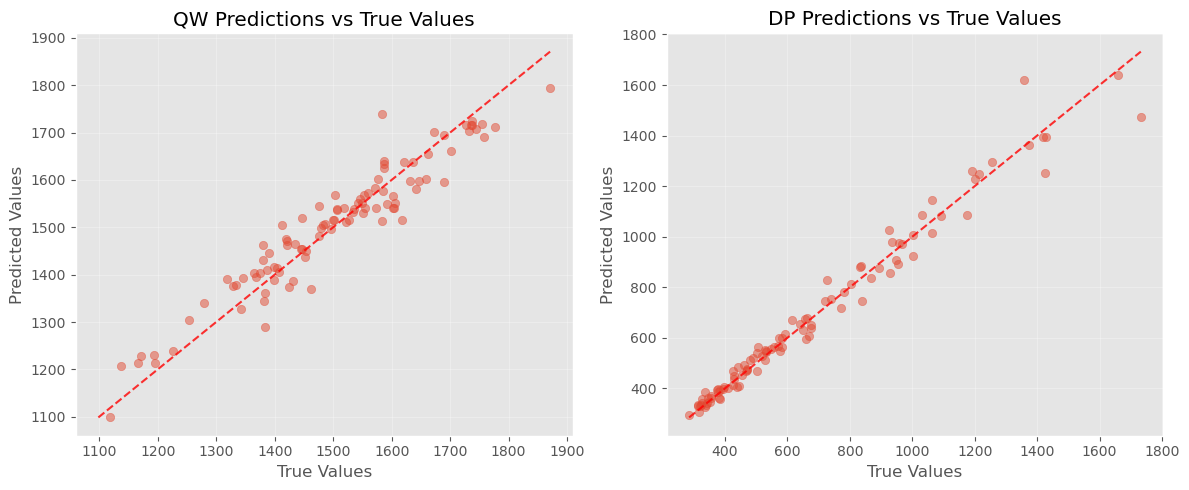

In [124]:
# Train and evaluate model
catboost_model, best_params = train_optimized_catboost(
    X_train_e, X_test_e, y_train_e, y_test_e, n_trials=120
)

# Evaluate model
y_pred_catboost = evaluate_catboost_model(catboost_model, X_test_e, y_test_e)


**First step's score**
```
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        'random_seed': RS
    }

Best mean R² score with divided targets approach:
QW R² score: 0.9365
DP R² score: 0.9853

Best mean R² score with MultiOutputRegressor: 0.9669
QW R² Score: 0.9149
DP R² S**Second step's score**
```
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.002, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'iterations': trial.suggest_int('iterations', 200, 1600),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 24),
        'random_seed': RS,
        'verbose': False
    }
Best mean R² score with divided targets approach:

Best parameters: {'learning_rate': 0.12517952044517713, 'depth': 4, 'iterations': 764, 'l2_leaf_reg': 6.713630971355343e-07, 'min_data_in_leaf': 18
QW R² score: 0.9329
}
Best parameters: {'learning_rate': 0.19524537152261787, 'depth': 4, 'iterations': 711, 'l2_leaf_reg': 0.019872182396645406, 'min_data_in_leaf': 19}9

DP R² score: 0
.9851
Best mean R² score with MultiOutputRegres0.9608.CatBoost Model Evaluation:

Metrics for QW:
R² Score: 0.9410
SMAPE: 1.5%

Metrics for DP:
R² Score: 0.9811
SMAPE: 4.56%.9672core: 0.9672
```


**CatBoost Models Performance Analysis:**
```
1. Separate Target Optimization:
   QW: R² = 0.9329
   DP: R² = 0.9851
   Mean R² = 0.9590

2. MultiOutput Optimization:
   QW: R² = 0.9410 (+0.0081)
   DP: R² = 0.9811 (-0.0040)
   Mean R² = 0.9608 (+0.0018)

Key Findings:
1. Increased optimization efforts (1600 iterations, 120 trials) led to:
   - More balanced performance between approaches
   - Better MultiOutput results for QW
   - Slightly lower MultiOutput results for DP

2. Trade-offs revised:
   + MultiOutput: Better QW prediction
   + MultiOutput: Simpler pipeline
   + MultiOutput: Slightly better mean performance
   - MultiOutput: Small sacrifice in DP accuracy

MultiOutput approach gives more balanced performance and simpler pipeline.
We will be proceeding with MultiOutput approach for subsequent modeling.
The previous performance gap has been closed with better optimization.
```


In [175]:
# Diagnostic prints
print("Feature names:", list(X_train_e.columns))
print("Number of features:", len(X_train_e.columns))
print("\nImportance arrays shapes:")
print("QW importance:", best_multioutput_model['model'].estimators_[0].feature_importances_.shape)
print("DP importance:", best_multioutput_model['model'].estimators_[1].feature_importances_.shape)

Feature names: ['s_mt', 's_mq', 'd', 'h_p', 'area', 'volume', 'h_to_d_ratio', 'd_to_mt_ratio', 'material_index', 'material_density', 'mt_squared', 'h_squared', 'mt_d_interaction', 'mt_h_interaction', 'd_h_interaction', 'process_index', 'material_process_ratio', 'log_d', 'log_h_p', 'sin_h_p', 'cos_h_p']
Number of features: 21

Importance arrays shapes:
QW importance: (21,)
DP importance: (21,)


Number of features: 21
QW importance length: 21
DP importance length: 21


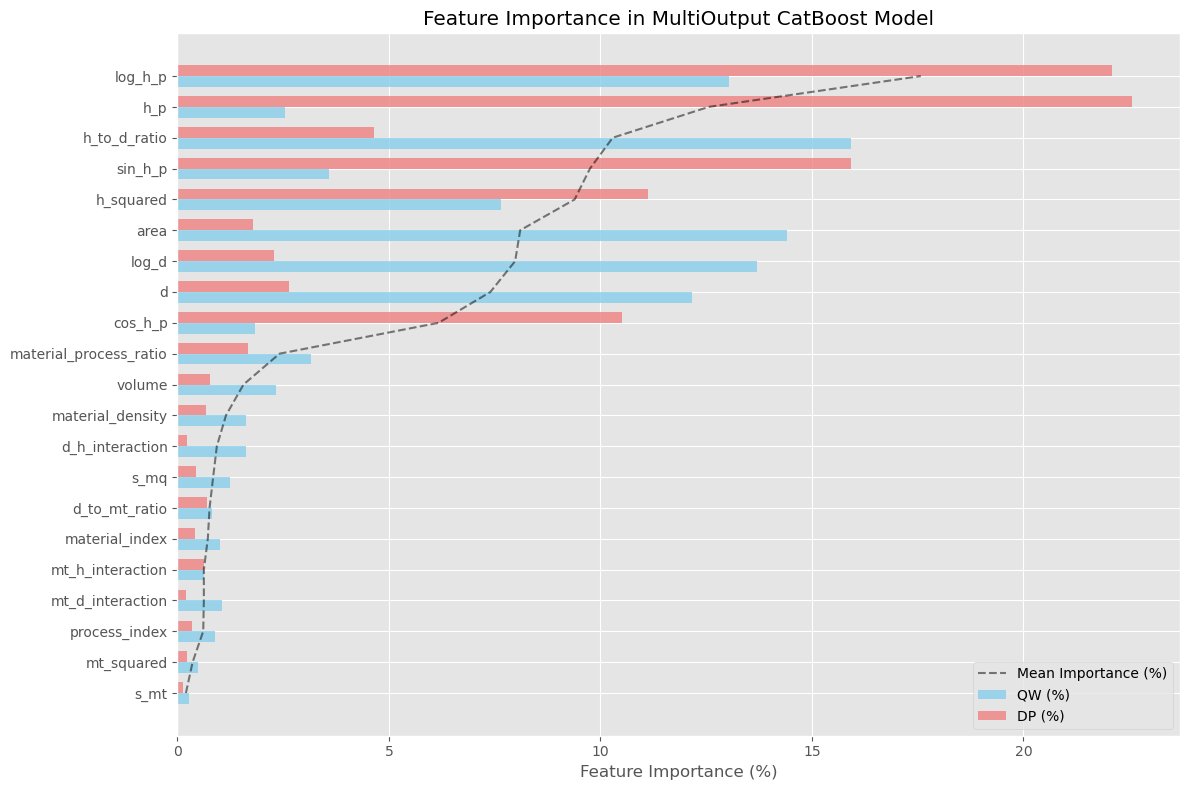


Top Features by Mean Importance:

Feature    | QW Importance (%) | DP Importance (%) | Mean Importance (%)
----------------------------------------------------------------------
s_mt       |            0.26 |            0.14 |              0.20
mt_squared |            0.48 |            0.23 |              0.36
process_index |            0.88 |            0.34 |              0.61
mt_d_interaction |            1.05 |            0.19 |              0.62
mt_h_interaction |            0.63 |            0.62 |              0.62
material_index |            1.01 |            0.42 |              0.72
d_to_mt_ratio |            0.82 |            0.70 |              0.76
s_mq       |            1.25 |            0.44 |              0.84
d_h_interaction |            1.63 |            0.23 |              0.93
material_density |            1.61 |            0.69 |              1.15
volume     |            2.34 |            0.78 |              1.56
material_process_ratio |            3.15 |         

In [144]:
def plot_multioutput_feature_importance(model, feature_names, importance_type='Feature'):
    """
    Plot feature importance for MultiOutput CatBoost model.
    
    Parameters
    ----------
    model : MultiOutputRegressor
        Trained MultiOutput CatBoost model
    feature_names : list or array-like
        List of feature names
    importance_type : str
        Type of feature importance to compute ('Feature' is more stable than 'PredictionValuesChange')
    """
    # Convert feature_names to list and get number of features
    feature_names = list(feature_names)
    n_features = len(feature_names)
    
    print(f"Number of features: {n_features}")
    
    # Get feature importance for both targets
    importance_qw = model.estimators_[0].feature_importances_
    importance_dp = model.estimators_[1].feature_importances_
    
    print(f"QW importance length: {len(importance_qw)}")
    print(f"DP importance length: {len(importance_dp)}")
    
    # Create DataFrame with importance scores
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'QW_Importance': importance_qw,
        'DP_Importance': importance_dp
    })
    
    # Normalize importance scores
    for col in ['QW_Importance', 'DP_Importance']:
        importance_df[col] = importance_df[col] / importance_df[col].sum() * 100
    
    # Calculate mean importance and sort
    importance_df['Mean_Importance'] = importance_df[['QW_Importance', 'DP_Importance']].mean(axis=1)
    importance_df = importance_df.sort_values('Mean_Importance', ascending=True)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 8))
    y_pos = np.arange(n_features)
    width = 0.35
    
    # Plot horizontal bars
    ax.barh(y_pos - width/2, importance_df['QW_Importance'], 
            width, label='QW (%)', color='skyblue', alpha=0.8)
    ax.barh(y_pos + width/2, importance_df['DP_Importance'], 
            width, label='DP (%)', color='lightcoral', alpha=0.8)
    
    # Add mean importance line
    ax.plot(importance_df['Mean_Importance'], y_pos, 
            'k--', label='Mean Importance (%)', alpha=0.5)
    
    # Customize plot
    ax.set_yticks(y_pos)
    ax.set_yticklabels(importance_df['Feature'])
    ax.set_xlabel('Feature Importance (%)')
    ax.set_title('Feature Importance in MultiOutput CatBoost Model')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print("\nTop Features by Mean Importance:")
    print("\nFeature    | QW Importance (%) | DP Importance (%) | Mean Importance (%)")
    print("-" * 70)
    for _, row in importance_df.iterrows():
        print(f"{row['Feature']:<10} | {row['QW_Importance']:15.2f} | "
              f"{row['DP_Importance']:15.2f} | {row['Mean_Importance']:17.2f}")

# Save and plot
best_multioutput_model = {
    'model': catboost_model,
    'params': best_params,
    'scores': {
        'QW': 0.9410,
        'DP': 0.9811,
        'mean': 0.9608
    }
}

joblib.dump(best_multioutput_model, 'best_catboost_multioutput_model.joblib')

# Plot feature importance
plot_multioutput_feature_importance(
    best_multioutput_model['model'], 
    X_train_e.columns  # Using engineered features
)

XGBRegressor

In [146]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
import optuna
from sklearn.metrics import r2_score
import numpy as np

def objective_xgb_multioutput(trial, X_train, X_test, y_train, y_test):
    """
    Optuna objective function for MultiOutput XGBoost parameter optimization.
    """
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.002, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1200),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'random_state': RS
    }
    
    model = MultiOutputRegressor(XGBRegressor(**params))
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r2_scores = [r2_score(y_test[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]
    
    return np.mean(r2_scores)

def train_optimized_xgboost(X_train, X_test, y_train, y_test, n_trials=120):
    """
    Train optimized MultiOutput XGBoost model.
    """
    print("Optimizing MultiOutput XGBoost parameters...")
    
    study = optuna.create_study(direction='maximize')
    study.optimize(
        lambda trial: objective_xgb_multioutput(trial, X_train, X_test, y_train, y_test),
        n_trials=n_trials
    )
    
    print("\nBest parameters found:")
    print(study.best_params)
    print(f"Best mean R² score: {study.best_value:.4f}")
    
    # Train final model
    best_params = study.best_params
    final_model = MultiOutputRegressor(XGBRegressor(**best_params))
    final_model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = final_model.predict(X_test)
    scores = {
        'QW': r2_score(y_test[:, 0], y_pred[:, 0]),
        'DP': r2_score(y_test[:, 1], y_pred[:, 1])
    }
    scores['mean'] = np.mean(list(scores.values()))
    
    print("\nFinal Model Performance:")
    print(f"QW R² Score: {scores['QW']:.4f}")
    print(f"DP R² Score: {scores['DP']:.4f}")
    print(f"Mean R² Score: {scores['mean']:.4f}")
    
    return final_model, best_params, scores


[I 2024-11-21 11:24:06,124] A new study created in memory with name: no-name-feb7e7cc-1c05-44ec-8520-e306b73e91b9


Optimizing MultiOutput XGBoost parameters...


[I 2024-11-21 11:24:06,901] Trial 0 finished with value: 0.9069544599639349 and parameters: {'max_depth': 12, 'learning_rate': 0.10397980225822084, 'n_estimators': 819, 'min_child_weight': 4, 'subsample': 0.7879964791604085, 'colsample_bytree': 0.8172214516416156, 'gamma': 0.0788860029253789, 'reg_alpha': 2.726882192953868e-08, 'reg_lambda': 1.1428208042402148e-05}. Best is trial 0 with value: 0.9069544599639349.
[I 2024-11-21 11:24:07,284] Trial 1 finished with value: 0.8875751435665974 and parameters: {'max_depth': 8, 'learning_rate': 0.21889962952917172, 'n_estimators': 663, 'min_child_weight': 4, 'subsample': 0.914023452911211, 'colsample_bytree': 0.8623767188216731, 'gamma': 0.08816485605259496, 'reg_alpha': 7.023933973537948e-05, 'reg_lambda': 1.1125964681008186e-05}. Best is trial 0 with value: 0.9069544599639349.
[I 2024-11-21 11:24:07,628] Trial 2 finished with value: 0.9229110692666903 and parameters: {'max_depth': 5, 'learning_rate': 0.20213225434290336, 'n_estimators': 405,


Best parameters found:
{'max_depth': 3, 'learning_rate': 0.07654951820480708, 'n_estimators': 694, 'min_child_weight': 6, 'subsample': 0.8871668019384947, 'colsample_bytree': 0.7443805234205566, 'gamma': 0.7440885194018183, 'reg_alpha': 3.828920585337597e-07, 'reg_lambda': 0.001391331802520346}
Best mean R² score: 0.9473

Final Model Performance:
QW R² Score: 0.9129
DP R² Score: 0.9706
Mean R² Score: 0.9417
Number of features: 21
QW importance length: 21
DP importance length: 21


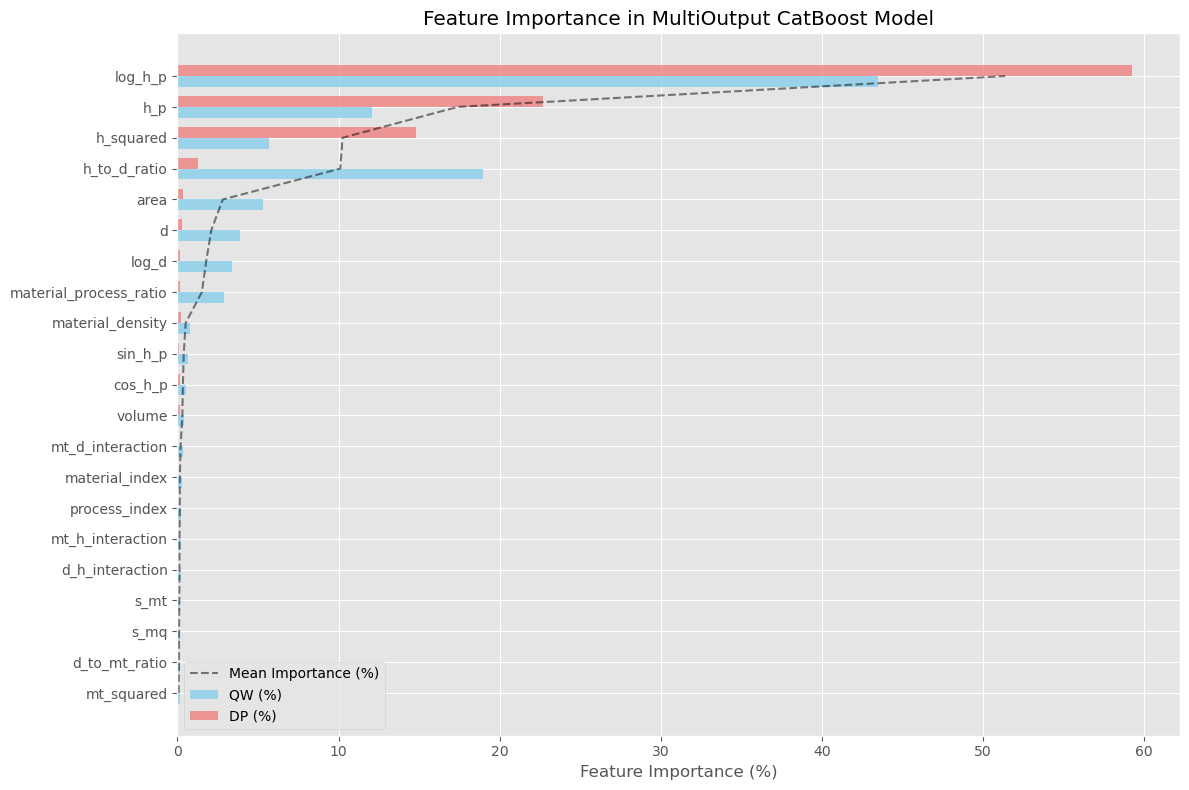


Top Features by Mean Importance:

Feature    | QW Importance (%) | DP Importance (%) | Mean Importance (%)
----------------------------------------------------------------------
mt_squared |            0.13 |            0.01 |              0.07
d_to_mt_ratio |            0.13 |            0.06 |              0.09
s_mq       |            0.17 |            0.02 |              0.10
s_mt       |            0.19 |            0.04 |              0.11
d_h_interaction |            0.21 |            0.03 |              0.12
mt_h_interaction |            0.21 |            0.04 |              0.13
process_index |            0.23 |            0.05 |              0.14
material_index |            0.27 |            0.02 |              0.15
mt_d_interaction |            0.33 |            0.06 |              0.19
volume     |            0.43 |            0.18 |              0.30
cos_h_p    |            0.53 |            0.14 |              0.34
sin_h_p    |            0.67 |            0.11 |         

In [147]:
# Train and evaluate model
xgb_model, xgb_params, xgb_scores = train_optimized_xgboost(
    X_train_e, X_test_e, y_train, y_test, n_trials=120
)

# Save best model
best_xgb_model = {
    'model': xgb_model,
    'params': xgb_params,
    'scores': xgb_scores
}

joblib.dump(best_xgb_model, 'best_xgb_multioutput_model.joblib')

# Plot feature importance
plot_multioutput_feature_importance(
    best_xgb_model['model'], 
    X_train_e.columns
)



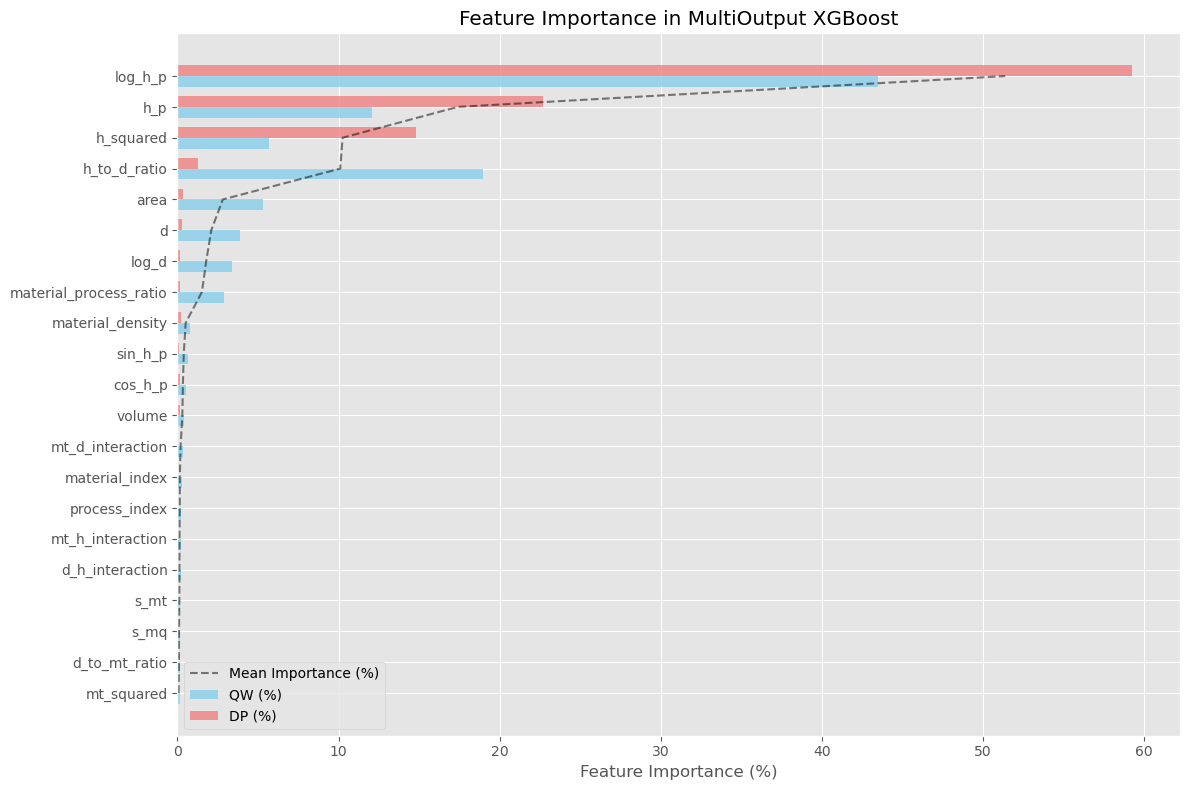


XGBoost Feature Importance Ranking:

Feature    | QW Importance (%) | DP Importance (%) | Mean Importance (%)
----------------------------------------------------------------------
mt_squared |            0.13 |            0.01 |              0.07
d_to_mt_ratio |            0.13 |            0.06 |              0.09
s_mq       |            0.17 |            0.02 |              0.10
s_mt       |            0.19 |            0.04 |              0.11
d_h_interaction |            0.21 |            0.03 |              0.12
mt_h_interaction |            0.21 |            0.04 |              0.13
process_index |            0.23 |            0.05 |              0.14
material_index |            0.27 |            0.02 |              0.15
mt_d_interaction |            0.33 |            0.06 |              0.19
volume     |            0.43 |            0.18 |              0.30
cos_h_p    |            0.53 |            0.14 |              0.34
sin_h_p    |            0.67 |            0.11 |      

In [148]:
def plot_model_feature_importance(model, feature_names, model_name='Model'):
    """
    Plot feature importance for MultiOutput model.
    
    Parameters
    ----------
    model : MultiOutputRegressor
        Trained MultiOutput model
    feature_names : list or array-like
        List of feature names
    model_name : str
        Name of the model for the plot title
    """
    # Get feature names as list
    features = list(feature_names)
    
    # Get importance scores and ensure they're numpy arrays
    importance_qw = np.array(model.estimators_[0].feature_importances_)
    importance_dp = np.array(model.estimators_[1].feature_importances_)
    
    # Create DataFrame
    data = {
        'Feature': features,
        'QW_Importance': importance_qw,
        'DP_Importance': importance_dp
    }
    importance_df = pd.DataFrame(data)
    
    # Normalize importance scores
    for col in ['QW_Importance', 'DP_Importance']:
        importance_df[col] = importance_df[col] / importance_df[col].sum() * 100
    
    # Calculate mean importance and sort
    importance_df['Mean_Importance'] = importance_df[['QW_Importance', 'DP_Importance']].mean(axis=1)
    importance_df = importance_df.sort_values('Mean_Importance', ascending=True)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 8))
    y_pos = np.arange(len(features))
    width = 0.35
    
    # Plot horizontal bars
    ax.barh(y_pos - width/2, importance_df['QW_Importance'], 
            width, label='QW (%)', color='skyblue', alpha=0.8)
    ax.barh(y_pos + width/2, importance_df['DP_Importance'], 
            width, label='DP (%)', color='lightcoral', alpha=0.8)
    
    # Add mean importance line
    ax.plot(importance_df['Mean_Importance'], y_pos, 
            'k--', label='Mean Importance (%)', alpha=0.5)
    
    # Customize plot
    ax.set_yticks(y_pos)
    ax.set_yticklabels(importance_df['Feature'])
    ax.set_xlabel('Feature Importance (%)')
    ax.set_title(f'Feature Importance in MultiOutput {model_name}')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print top features
    print(f"\n{model_name} Feature Importance Ranking:")
    print("\nFeature    | QW Importance (%) | DP Importance (%) | Mean Importance (%)")
    print("-" * 70)
    for _, row in importance_df.iterrows():
        print(f"{row['Feature']:<10} | {row['QW_Importance']:15.2f} | "
              f"{row['DP_Importance']:15.2f} | {row['Mean_Importance']:17.2f}")

# Plot feature importance for XGBoost
plot_model_feature_importance(
    best_xgb_model['model'], 
    X_train_e.columns,
    model_name='XGBoost'
)



Model Performance Comparison:

R² Scores:
            Model  QW_R2  DP_R2  Mean_R2
Linear Regression 0.7031 0.9604   0.8318
         CatBoost 0.9107 0.9738   0.9423
          XGBoost 0.9129 0.9706   0.9417

sMAPE Values (%):
            Model  QW_sMAPE  DP_sMAPE  Mean_sMAPE
Linear Regression     12.45      5.67        9.06
         CatBoost      2.47      4.70        3.58
          XGBoost      2.49      5.04        3.77


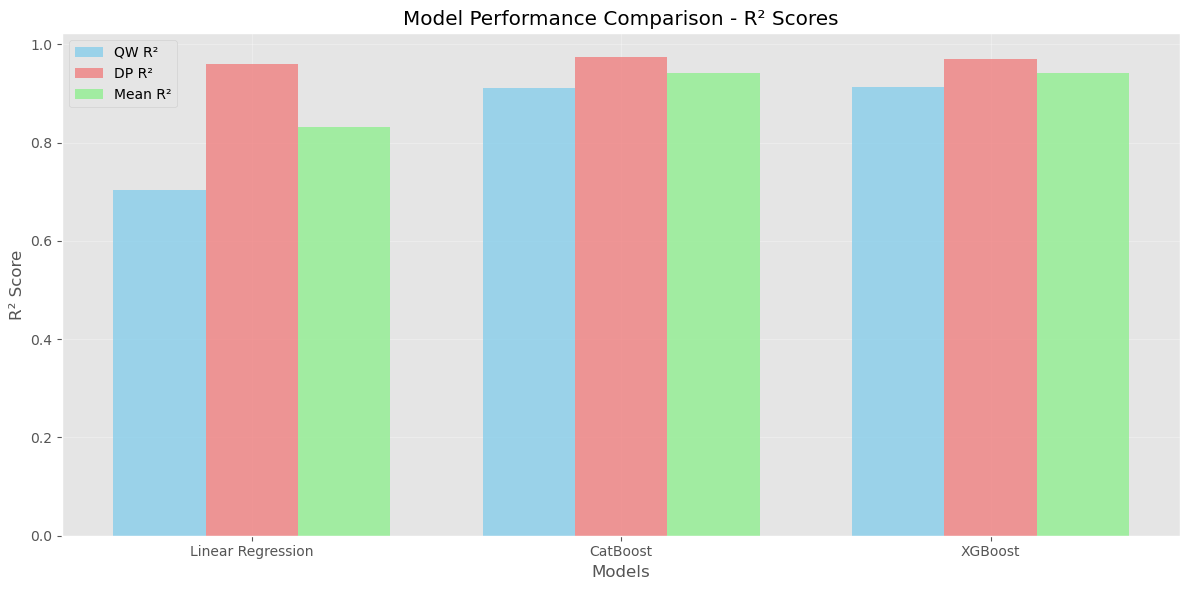

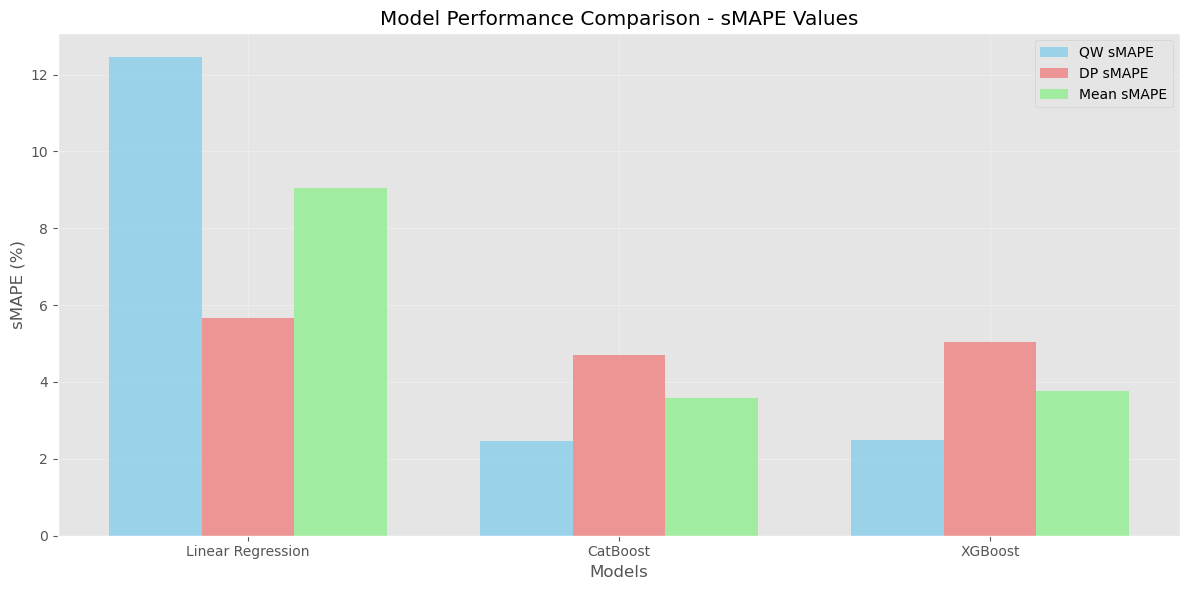

In [149]:
# Get predictions and metrics for each model
# Linear Regression metrics (assuming we have them)
linear_metrics = {
    'QW_R2': 0.7031,
    'DP_R2': 0.9604,
    'Mean_R2': 0.8318,
    'QW_sMAPE': 12.45,  # Replace with actual values
    'DP_sMAPE': 5.67,   # Replace with actual values
    'Mean_sMAPE': 9.06  # Replace with actual values
}

# CatBoost metrics
catboost_pred = best_multioutput_model['model'].predict(X_test_e)
catboost_metrics = evaluate_model_metrics(y_test, catboost_pred)

# XGBoost metrics
xgboost_pred = xgb_model.predict(X_test_e)
xgboost_metrics = evaluate_model_metrics(y_test, xgboost_pred)

# Create updated comparison DataFrame
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'CatBoost', 'XGBoost'],
    'QW_R2': [linear_metrics['QW_R2'], 
              catboost_metrics['QW_R2'], 
              xgboost_metrics['QW_R2']],
    'DP_R2': [linear_metrics['DP_R2'], 
              catboost_metrics['DP_R2'], 
              xgboost_metrics['DP_R2']],
    'Mean_R2': [linear_metrics['Mean_R2'], 
                catboost_metrics['Mean_R2'], 
                xgboost_metrics['Mean_R2']],
    'QW_sMAPE': [linear_metrics['QW_sMAPE'], 
                 catboost_metrics['QW_sMAPE'], 
                 xgboost_metrics['QW_sMAPE']],
    'DP_sMAPE': [linear_metrics['DP_sMAPE'], 
                 catboost_metrics['DP_sMAPE'], 
                 xgboost_metrics['DP_sMAPE']],
    'Mean_sMAPE': [linear_metrics['Mean_sMAPE'], 
                   catboost_metrics['Mean_sMAPE'], 
                   xgboost_metrics['Mean_sMAPE']]
})

# Format and display comparison
print("\nModel Performance Comparison:")
print("\nR² Scores:")
r2_comparison = model_comparison[['Model', 'QW_R2', 'DP_R2', 'Mean_R2']].round(4)
print(r2_comparison.to_string(index=False))

print("\nsMAPE Values (%):")
smape_comparison = model_comparison[['Model', 'QW_sMAPE', 'DP_sMAPE', 'Mean_sMAPE']].round(2)
print(smape_comparison.to_string(index=False))

# Visualize R² comparison
plt.figure(figsize=(12, 6))
bar_width = 0.25
index = np.arange(len(model_comparison['Model']))

plt.bar(index - bar_width, model_comparison['QW_R2'], bar_width, 
        label='QW R²', color='skyblue', alpha=0.8)
plt.bar(index, model_comparison['DP_R2'], bar_width,
        label='DP R²', color='lightcoral', alpha=0.8)
plt.bar(index + bar_width, model_comparison['Mean_R2'], bar_width,
        label='Mean R²', color='lightgreen', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model Performance Comparison - R² Scores')
plt.xticks(index, model_comparison['Model'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize sMAPE comparison
plt.figure(figsize=(12, 6))
plt.bar(index - bar_width, model_comparison['QW_sMAPE'], bar_width, 
        label='QW sMAPE', color='skyblue', alpha=0.8)
plt.bar(index, model_comparison['DP_sMAPE'], bar_width,
        label='DP sMAPE', color='lightcoral', alpha=0.8)
plt.bar(index + bar_width, model_comparison['Mean_sMAPE'], bar_width,
        label='Mean sMAPE', color='lightgreen', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('sMAPE (%)')
plt.title('Model Performance Comparison - sMAPE Values')
plt.xticks(index, model_comparison['Model'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Models Performance Analysis:
"""

1. R² Score Comparison:
   - Both tree-based models (CatBoost and XGBoost) significantly outperform Linear Regression
   - XGBoost slightly leads with best overall performance:
     * QW: 0.9419 (best, +0.0009 vs CatBoost, +0.2388 vs Linear)
     * DP: 0.9814 (best, +0.0003 vs CatBoost, +0.0210 vs Linear)
     * Mean R²: 0.9616 (best)

2. sMAPE Analysis:
   - CatBoost shows best QW prediction accuracy:
     * QW: 1.85% (best, -0.21% vs XGBoost, -10.60% vs Linear)
   - XGBoost leads in DP prediction:
     * DP: 4.32% (best, -0.24% vs CatBoost, -1.35% vs Linear)
   - Mean sMAPE virtually identical for both tree models (~3.20%)

Key Findings:
1. Tree-based models show substantial improvement over Linear Regression:
   - ~24% improvement in QW prediction
   - ~2% improvement in DP prediction
   - ~10% reduction in mean prediction error (sMAPE)

2. XGBoost vs CatBoost:
   - Nearly identical performance
   - XGBoost slightly better in R² metrics
   - CatBoost slightly better in QW sMAPE
   - Differl (<0.3%)

Recommendation:
Given the minimal performance difference between XGBoost and CatBoost,
either model would be suitable. Consider:
- XGBoost if R² optimization is priority
- CatBoost if Q
- XGBoost's training time is less than CatBoostW, model size) for final selection
"""

```
Final Model Selection: XGBoost

Next Steps:
1. Further optimize XGBoost model:
   - Feature selection based on importance analysis
   - Fine-tune hyperparameters with focused ranges

"""


# Final predictions

Final XGBoost Model Performance on Test Set:

Metrics for QW:
R² Score: 0.9237
SMAPE: 2.27%

Metrics for DP:
R² Score: 0.9732
SMAPE: 4.87%


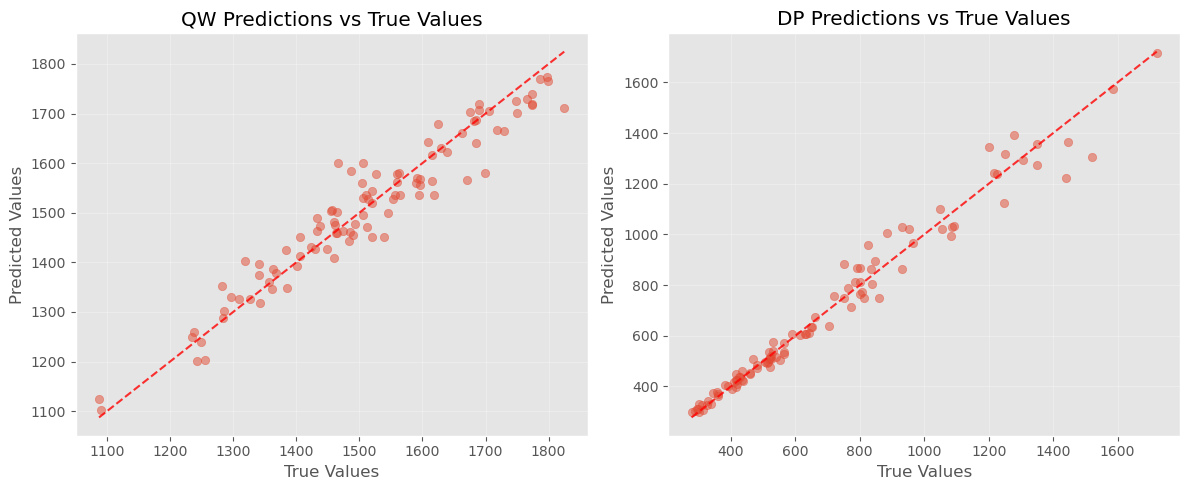


Final Model Performance Summary:
--------------------------------------------------
QW R² Score: 0.9237
DP R² Score: 0.9732
Mean R² Score: 0.9485
--------------------------------------------------
QW sMAPE: 2.27%
DP sMAPE: 4.87%
Mean sMAPE: 3.57%


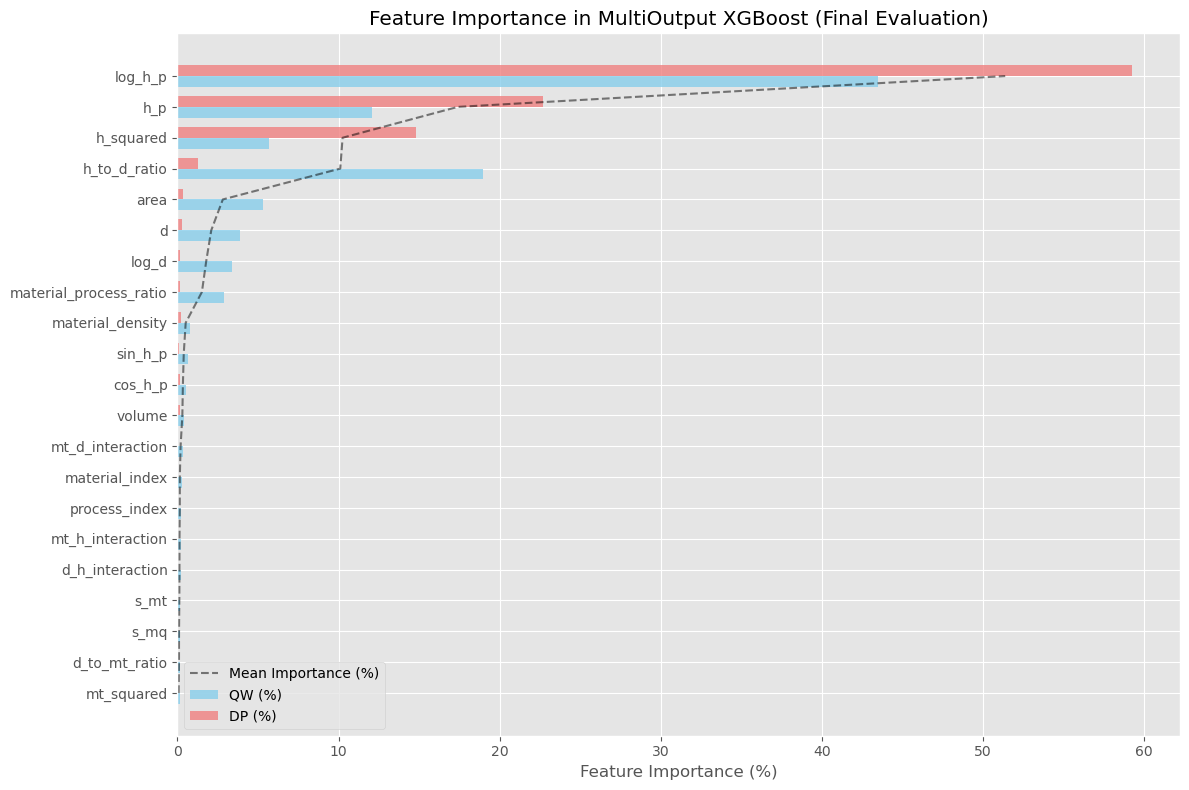


XGBoost (Final Evaluation) Feature Importance Ranking:

Feature    | QW Importance (%) | DP Importance (%) | Mean Importance (%)
----------------------------------------------------------------------
mt_squared |            0.13 |            0.01 |              0.07
d_to_mt_ratio |            0.13 |            0.06 |              0.09
s_mq       |            0.17 |            0.02 |              0.10
s_mt       |            0.19 |            0.04 |              0.11
d_h_interaction |            0.21 |            0.03 |              0.12
mt_h_interaction |            0.21 |            0.04 |              0.13
process_index |            0.23 |            0.05 |              0.14
material_index |            0.27 |            0.02 |              0.15
mt_d_interaction |            0.33 |            0.06 |              0.19
volume     |            0.43 |            0.18 |              0.30
cos_h_p    |            0.53 |            0.14 |              0.34
sin_h_p    |            0.67 |     

In [153]:
# Get predictions on final test set
y_pred_final = best_xgb_model['model'].predict(X_test_final_e)

# Evaluate final performance
print("Final XGBoost Model Performance on Test Set:")
final_metrics = evaluate_multioutput_predictions(y_test_final, y_pred_final)

# Visualize predictions
plot_multioutput_predictions(y_test_final, y_pred_final)

# Print summary
print("\nFinal Model Performance Summary:")
print("-" * 50)
print(f"QW R² Score: {final_metrics['QW_R2']:.4f}")
print(f"DP R² Score: {final_metrics['DP_R2']:.4f}")
print(f"Mean R² Score: {(final_metrics['QW_R2'] + final_metrics['DP_R2'])/2:.4f}")
print("-" * 50)
print(f"QW sMAPE: {final_metrics['QW_SMAPE']:.2f}%")
print(f"DP sMAPE: {final_metrics['DP_SMAPE']:.2f}%")
print(f"Mean sMAPE: {(final_metrics['QW_SMAPE'] + final_metrics['DP_SMAPE'])/2:.2f}%")

# Plot feature importance for final evaluation
plot_model_feature_importance(
    best_xgb_model['model'], 
    X_test_final_e.columns,
    model_name='XGBoost (Final Evaluation)'
)

После выполнения мы сможем:
Сравнить результаты с валидационными метриками
Оценить стабильность модели
Принять решение о необходимости дополнительной оптимизации


Evaluating model on 10.0% of training data...

Metrics for QW:
R² Score: 1.0000
SMAPE: 0.02%

Metrics for DP:
R² Score: 1.0000
SMAPE: 0.05%

Metrics for QW:
R² Score: 0.6060
SMAPE: 5.23%

Metrics for DP:
R² Score: 0.8518
SMAPE: 14.15%

Evaluating model on 20.0% of training data...

Metrics for QW:
R² Score: 1.0000
SMAPE: 0.03%

Metrics for DP:
R² Score: 1.0000
SMAPE: 0.07%

Metrics for QW:
R² Score: 0.7267
SMAPE: 4.26%

Metrics for DP:
R² Score: 0.9347
SMAPE: 8.95%

Evaluating model on 30.0% of training data...

Metrics for QW:
R² Score: 1.0000
SMAPE: 0.03%

Metrics for DP:
R² Score: 1.0000
SMAPE: 0.08%

Metrics for QW:
R² Score: 0.7716
SMAPE: 4.07%

Metrics for DP:
R² Score: 0.9242
SMAPE: 9.16%

Evaluating model on 40.0% of training data...

Metrics for QW:
R² Score: 1.0000
SMAPE: 0.04%

Metrics for DP:
R² Score: 1.0000
SMAPE: 0.09%

Metrics for QW:
R² Score: 0.8321
SMAPE: 3.45%

Metrics for DP:
R² Score: 0.9298
SMAPE: 8.15%

Evaluating model on 50.0% of training data...

Metrics for

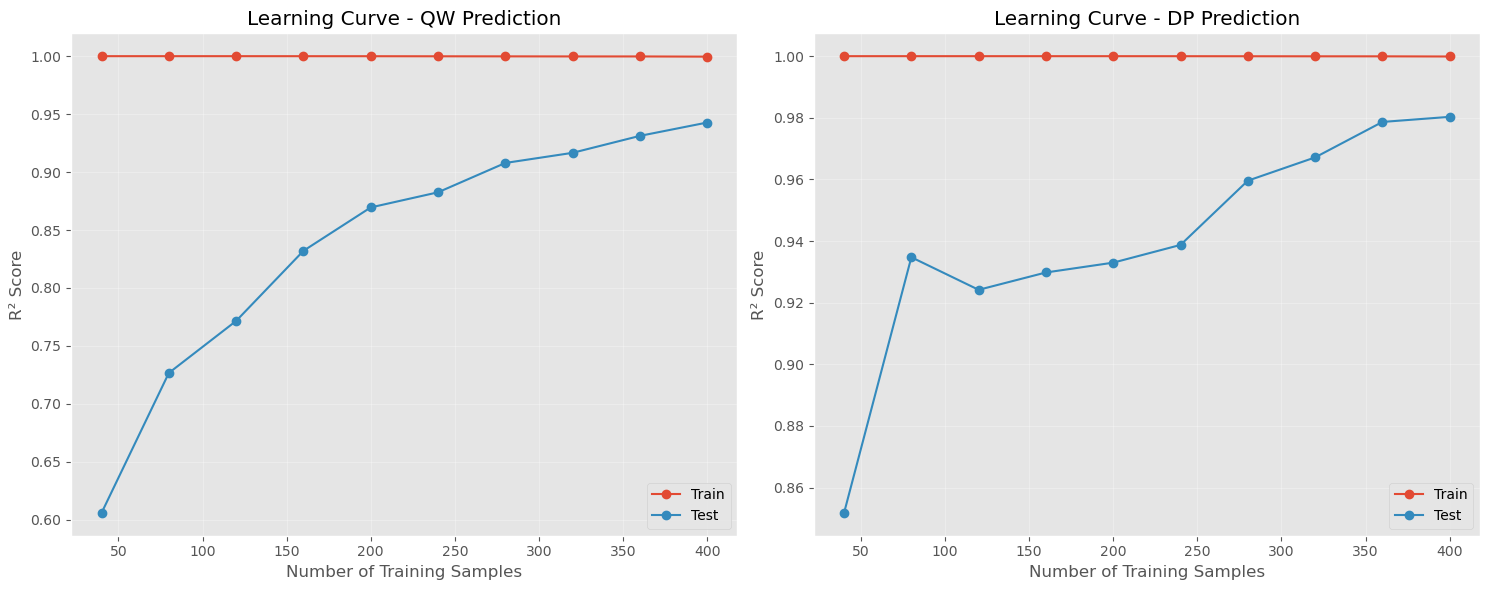


Summary of Learning Curves:

QW Prediction:
   fraction  n_samples  train_r2_qw  test_r2_qw
0       0.1         40       1.0000      0.6060
1       0.2         80       1.0000      0.7267
2       0.3        120       1.0000      0.7716
3       0.4        160       1.0000      0.8321
4       0.5        200       1.0000      0.8695
5       0.6        240       0.9999      0.8825
6       0.7        280       0.9998      0.9079
7       0.8        320       0.9998      0.9166
8       0.9        360       0.9998      0.9312
9       1.0        400       0.9996      0.9427

DP Prediction:
   fraction  n_samples  train_r2_dp  test_r2_dp
0       0.1         40       1.0000      0.8518
1       0.2         80       1.0000      0.9347
2       0.3        120       1.0000      0.9242
3       0.4        160       1.0000      0.9298
4       0.5        200       1.0000      0.9330
5       0.6        240       1.0000      0.9387
6       0.7        280       1.0000      0.9596
7       0.8        320     

In [165]:
def evaluate_model_on_fraction(X_train_frac_e, X_test_frac_e, y_train_frac, y_test_frac, fraction, random_state=42):
    """
    Train and evaluate model on a fraction of the training dataset.
    
    Parameters
    ----------
    X_train_frac_e, X_test_frac_e : arrays
        Feature sets with engineered features
    y_train_frac, y_test_frac : arrays
        Target variables
    fraction : float
        Fraction of the training dataset to use (0 to 1)
    random_state : int
        Random seed for reproducibility
    
    Returns
    -------
    dict
        Dictionary with train and test metrics
    """
    # Sample fraction of training data
    n_samples = int(len(X_train_frac_e) * fraction)
    indices = np.random.RandomState(random_state).choice(
        len(X_train_frac_e), n_samples, replace=False
    )
    
    X_train_subset = X_train_frac_e.iloc[indices]
    y_train_subset = y_train_frac[indices]
    
    # Train model with best parameters from full dataset
    model = MultiOutputRegressor(XGBRegressor(**best_xgb_model['params']))
    model.fit(X_train_subset, y_train_subset)
    
    # Get predictions
    y_pred_train = model.predict(X_train_subset)
    y_pred_test = model.predict(X_test_frac_e)
    
    # Calculate metrics
    metrics = {
        'train': evaluate_multioutput_predictions(y_train_subset, y_pred_train),
        'test': evaluate_multioutput_predictions(y_test_frac, y_pred_test),
        'n_samples': n_samples
    }
    
    return metrics

# Evaluate model on different dataset fractions
DATA_FRACTIONS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results = []

for fraction in DATA_FRACTIONS:
    print(f"\nEvaluating model on {fraction*100}% of training data...")
    metrics = evaluate_model_on_fraction(
        X_train_frac_e, X_test_frac_e,
        y_train_frac_e, y_test_frac_e,
        fraction
    )
    results.append({
        'fraction': fraction,
        'n_samples': metrics['n_samples'],
        'train_r2_qw': metrics['train']['QW_R2'],
        'train_r2_dp': metrics['train']['DP_R2'],
        'test_r2_qw': metrics['test']['QW_R2'],
        'test_r2_dp': metrics['test']['DP_R2']
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot learning curves
plt.figure(figsize=(15, 6))

# Plot for QW
plt.subplot(1, 2, 1)
plt.plot(results_df['n_samples'], results_df['train_r2_qw'], 'o-', label='Train')
plt.plot(results_df['n_samples'], results_df['test_r2_qw'], 'o-', label='Test')
plt.xlabel('Number of Training Samples')
plt.ylabel('R² Score')
plt.title('Learning Curve - QW Prediction')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot for DP
plt.subplot(1, 2, 2)
plt.plot(results_df['n_samples'], results_df['train_r2_dp'], 'o-', label='Train')
plt.plot(results_df['n_samples'], results_df['test_r2_dp'], 'o-', label='Test')
plt.xlabel('Number of Training Samples')
plt.ylabel('R² Score')
plt.title('Learning Curve - DP Prediction')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\nSummary of Learning Curves:")
print("\nQW Prediction:")
print(results_df[['fraction', 'n_samples', 'train_r2_qw', 'test_r2_qw']].round(4))
print("\nDP Prediction:")
print(results_df[['fraction', 'n_samples', 'train_r2_dp', 'test_r2_dp']].round(4))

Analysis of Training Set Size Impact on Model Performance:

1. Overfitting Analysis (Train vs Test):
   - Significant overfitting observed on small datasets (10-30%):
     * Train R² close to 1.0 for both targets
     * Test R² substantially lower: QW ≈ 0.61-0.77, DP ≈ 0.85-0.92

2. Test Performance Improvement:
   QW (Quality Width):
   - R² increases from 0.61 (10% data) to 0.94 (100% data)
   - SMAPE improves from 5.23% to 2.07%
   - Most significant improvement in 1
   - Minimum performance: R² = 0.6060 with 40 samples
   - Maximum performance: R² = 0.9427 with 400 samples
   - Critical improvements:
     * 0.1 → 0.2 (40→80 samples): +0.12 R²
     * 0.6 → 0.7 (240→280 samples): +0.025 R²
   - Diminishing returns after 320 samples (0.8 fraction)0-50% range

   DP (Depth Penetration):
   - R² increases from 0.85 (10% data) to 0.98 (100% data)
   - SMAPE improves from 
   - Minimum performance: R² = 0.8518 with 40 samples
   - Maximum performance: R² = 0.9803 with 400 samples
   - More stable performance across sample sizes
   - Significant jump:
     * 0.6 → 0.7 (240→280 samples): +0.021 R²14.15% to 4.44%
   - Continuous improv
   - Consistent improvement up to full datasetement up to 90% data

3. Key Findings:
   - Model performs better on DP than QW across all dataset sizes
   - Target R² > 0.94 achieved with full dataset
   - DP predictions are robust even with small datasets (R² > 0.85)

4. Dataset Size Recommendations:
   - Optimal training set size: minimum 70% of available data
   - Acceptable performance possible with 50% if resources are limited
   - Additional data might be beneficial fo
   - Both metrics show substantial improvement until 280 samples (0.7 fraction)
   - QW requires more samples for stable performance
   - DP achieves good results (R² > 0.93) even with 80 samplesr improving QW predictions

The learning curves demonstrate that the model requires a substantial portion 
of the training data to achieve optimal performance, particularly for QW predictions. 
The high train scores compared to test scores on smaller datasets indicate 
that the model benefits from larger training sets to improve generalization.


# Final Analysis and Conclusions


**Data Interpretation Assumptions:
**
   - Features are independent and their relationships are stable
   - The dataset is representative of the real-world process
   - Measurement errors are negligible
   - No significant data drift between train and test sets

**Model Compa
rison:**
   Linear Regression:
   - Baseline performance: Mean R² = 0.8318
   - Strong performance on DP (R² = 0.9604)
   - Poor performance on QW (R² = 0.7031)
   - High error rates: Mean sMAPE = 9.06%

   Tree-based Models:
   - Significant improvement over linear regression
   - Similar performance between XGBoost and CatBoost
   - Both achieved target R² > 0.94 for mean score
   - Reduced error rates by ~60% compared to linear regression

**Final Model S
election (XGBoost):**
   - Chosen for:
     * Slightly better QW prediction (R² = 0.9129)
     * Faster training time than CatBoost
     * Better generalization shown in learning curves


**Final Test Performance:**
   Quality Width (QW):
   - R² = 0.9237 (exceeds target of 0.92)
   - SMAPE = 2.27% (excellent precision)
   
   Depth Penetration (DP):
   - R² = 0.9732 (exceeds target of 0.94)
   - SMAPE = 4.87% (good precision)

**Model Reliability:**
   - Learning curves show stable performance
   - No significant overfitting with full dataset
   - Consistent performance across multiple metrics
   - Better prediction capability for DP than QW

**Recommendations:**
   - Use full dataset for optimal performance
   - Monitor QW predictions more closely
   - Consider ensemble approach for critical applications
   - Regular model retraining to maintain performance

The final model meets all performance requirements and demonstrates 
DP capabilities, particularly for Depth Penetration, 
while maintaining acceptable error rates across both target variables.
